In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score

from PIL import Image
import io, pickle
from tqdm import tqdm, trange
import numpy as np

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('images/images.pickle', 'rb') as f:
    img_data = pickle.load(f)
class CustomDataset(Dataset):
    def __init__(self, img_data, txt_file, transform=None):
        self.data = img_data
        with open(txt_file, 'r') as f:
            self.labels = f.readlines()
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_path, label = self.labels[idx].strip().split()
        img_path = img_path.split('/')
        img = self.data[img_path[1]][img_path[2]]
        img = Image.open(io.BytesIO(img)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(label)
        return img, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset_train = CustomDataset(img_data=img_data, txt_file='images/train.txt', transform=transform)
dataset_val = CustomDataset(img_data=img_data, txt_file='images/val.txt', transform=transform)
dataset_test = CustomDataset(img_data=img_data, txt_file='images/test.txt', transform=transform)


data_loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, )
data_loader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class CNNModel(nn.Module):

    def __init__(self, num_classes=50):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512*14*14, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.pool(self.activation(self.bn4(self.conv4(x))))
        x = self.dropout25(self.flatten(x))
        x = self.dropout50(self.activation(self.fc1(x)))
        x = self.dropout50(self.activation(self.fc2(x)))
        # x = self.flatten(x)
        # x = self.gelu(self.fc1(x))
        # x = self.gelu(self.fc2(x))
        x = self.fc3(x)
        return x


for lr in [1e-6, 1e-5, 1e-4]:
    model = CNNModel(num_classes=50).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    num_epochs = 50
    save_path = 'record/Q1_baseline'
    model_path = f'{save_path}/model_weight/model_weight_lr{lr}_bn_dropout.pth'
    best_val_loss = float('inf')
    best_model = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        pbar = tqdm(data_loader_train, colour='green', total=len(data_loader_train))
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Train Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()
        running_loss_avg = running_loss / len(dataset_train)
        running_acc_avg = running_acc / len(dataset_train)
        train_loss.append(running_loss_avg)
        train_acc.append(running_acc_avg)
        print(f"Epoch {epoch+1}, Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")

        model.eval()
        with torch.no_grad():
            class_counts = [0] * 50
            running_loss = 0.0
            running_acc = 0.0
            pbar = tqdm(data_loader_val, colour='red', total=len(data_loader_val))
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predictions = outputs.argmax(dim=1)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*len(labels)
                running_acc += (predictions == labels).float().sum().item()
                pbar.set_description(f'Valid Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
                pbar.update()

                for pred_label in predictions:
                    class_counts[pred_label] += 1

            running_loss_avg = running_loss / len(dataset_val)
            running_acc_avg = running_acc / len(dataset_val)
            val_loss.append(running_loss_avg)
            val_acc.append(running_acc_avg)
            print(f"Validation Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")
            print(f"Class Counts: {class_counts}")
            if running_loss_avg < best_val_loss:
                best_val_loss = running_loss
                best_model = model
                torch.save(model.state_dict(), model_path)
        print("======================================")
    print("Finished Training")


    model.eval()
    with torch.no_grad():
        class_counts = [0] * 50
        running_loss = 0.0
        running_acc = 0.0
        predictions = []
        true_labels = []
        pbar = tqdm(data_loader_test, colour='red', total=len(data_loader_test))
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Test Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()

        for pred_label in predictions:
            class_counts[pred_label] += 1
        
        precision = precision_score(true_labels, predictions, average='weighted')
        recall = recall_score(true_labels, predictions, average='weighted')
        f1 = f1_score(true_labels, predictions, average='weighted')
        print(f"Test Loss: {running_loss/len(dataset_test)}, Accuracy: {running_acc/len(dataset_test)}")
        print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
        print(f"Class Counts: {class_counts}")
    print("Finished Testing")

    train_record = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
    test_record = {"precision": precision, "recall": recall, "f1": f1, "class_counts": class_counts}

    with open(f'{save_path}/train_record/train_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
        pickle.dump(train_record, f)
    with open(f'{save_path}/test_record/test_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
        pickle.dump(test_record, f)


Train Iter: 001/050  Loss: 3.4258: 100%|██████████| 1979/1979 [03:46<00:00,  8.74it/s]


Epoch 1, Loss: 3.7061687708032776, Accuracy: 0.07387287801026451


Valid Iter: 001/050  Loss: 2.9207: 100%|██████████| 15/15 [00:00<00:00, 23.22it/s]


Validation Loss: 3.375898169411553, Accuracy: 0.1622222222222222
Class Counts: [31, 1, 12, 16, 24, 0, 1, 2, 0, 0, 0, 0, 0, 0, 41, 10, 0, 0, 10, 0, 13, 4, 7, 3, 5, 8, 0, 27, 23, 0, 3, 0, 4, 20, 44, 2, 7, 5, 2, 15, 12, 0, 6, 9, 12, 9, 9, 3, 32, 18]


Train Iter: 002/050  Loss: 3.5844: 100%|██████████| 1979/1979 [03:42<00:00,  8.90it/s]


Epoch 2, Loss: 3.423863945843154, Accuracy: 0.12330043426766679


Valid Iter: 002/050  Loss: 2.5764: 100%|██████████| 15/15 [00:00<00:00, 24.29it/s]


Validation Loss: 3.1460593138800728, Accuracy: 0.18
Class Counts: [18, 0, 16, 11, 23, 9, 5, 6, 0, 3, 0, 0, 0, 4, 12, 18, 7, 0, 6, 4, 17, 6, 8, 11, 7, 2, 2, 23, 2, 10, 3, 0, 4, 30, 30, 3, 5, 15, 5, 14, 9, 12, 5, 8, 11, 11, 21, 1, 22, 11]


Train Iter: 003/050  Loss: 3.8407: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 3, Loss: 3.2801686669337244, Accuracy: 0.148503750493486


Valid Iter: 003/050  Loss: 2.3224: 100%|██████████| 15/15 [00:00<00:00, 23.96it/s]


Validation Loss: 3.0212399948967827, Accuracy: 0.20222222222222222
Class Counts: [16, 2, 11, 18, 33, 14, 4, 1, 1, 0, 0, 0, 0, 0, 2, 11, 1, 6, 10, 5, 16, 4, 11, 28, 3, 2, 2, 16, 8, 8, 12, 0, 5, 28, 19, 5, 10, 11, 2, 9, 11, 16, 4, 12, 12, 12, 15, 4, 21, 9]


Train Iter: 004/050  Loss: 3.0051: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 4, Loss: 3.1772732807758812, Accuracy: 0.16679036715357284


Valid Iter: 004/050  Loss: 2.0003: 100%|██████████| 15/15 [00:00<00:00, 23.36it/s]


Validation Loss: 2.931801135804918, Accuracy: 0.22444444444444445
Class Counts: [13, 12, 8, 11, 31, 9, 9, 0, 1, 0, 0, 0, 0, 4, 12, 20, 10, 2, 14, 6, 17, 3, 13, 16, 4, 8, 2, 28, 4, 6, 1, 0, 15, 20, 10, 4, 7, 12, 7, 9, 6, 12, 3, 11, 7, 10, 17, 5, 18, 13]


Train Iter: 005/050  Loss: 2.9960: 100%|██████████| 1979/1979 [03:40<00:00,  8.96it/s]


Epoch 5, Loss: 3.0981539984686877, Accuracy: 0.18299249901302803


Valid Iter: 005/050  Loss: 1.9012: 100%|██████████| 15/15 [00:00<00:00, 23.80it/s]


Validation Loss: 2.869548667271932, Accuracy: 0.2311111111111111
Class Counts: [6, 6, 12, 8, 35, 13, 4, 1, 2, 1, 1, 0, 0, 6, 8, 6, 3, 5, 13, 7, 15, 6, 10, 16, 8, 12, 1, 13, 7, 6, 1, 3, 8, 31, 15, 9, 11, 10, 6, 14, 8, 19, 9, 8, 5, 11, 18, 1, 20, 12]


Train Iter: 006/050  Loss: 2.9275: 100%|██████████| 1979/1979 [03:40<00:00,  8.96it/s]


Epoch 6, Loss: 3.0314902852657424, Accuracy: 0.198499802605606


Valid Iter: 006/050  Loss: 1.5902: 100%|██████████| 15/15 [00:00<00:00, 24.03it/s]


Validation Loss: 2.8112670034832425, Accuracy: 0.2288888888888889
Class Counts: [6, 6, 17, 12, 29, 11, 4, 6, 0, 0, 0, 1, 0, 6, 9, 15, 7, 4, 4, 11, 13, 8, 18, 12, 3, 13, 0, 5, 8, 9, 6, 0, 14, 16, 8, 10, 9, 11, 8, 14, 10, 15, 4, 18, 6, 11, 16, 3, 20, 14]


Train Iter: 007/050  Loss: 3.0165: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 7, Loss: 2.967298018161459, Accuracy: 0.20871693643900513


Valid Iter: 007/050  Loss: 1.5784: 100%|██████████| 15/15 [00:00<00:00, 23.54it/s]


Validation Loss: 2.7657074806425306, Accuracy: 0.26222222222222225
Class Counts: [10, 3, 21, 7, 20, 11, 7, 13, 3, 1, 0, 0, 1, 4, 18, 10, 9, 7, 6, 14, 11, 9, 14, 6, 4, 11, 6, 16, 8, 4, 3, 0, 5, 17, 20, 9, 5, 9, 11, 15, 6, 6, 4, 20, 7, 8, 18, 4, 19, 10]


Train Iter: 008/050  Loss: 2.7280: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 8, Loss: 2.917092212047494, Accuracy: 0.22131859455191472


Valid Iter: 008/050  Loss: 1.5956: 100%|██████████| 15/15 [00:00<00:00, 24.63it/s]


Validation Loss: 2.727435704337226, Accuracy: 0.24888888888888888
Class Counts: [8, 3, 23, 18, 21, 10, 7, 1, 2, 0, 0, 0, 2, 6, 10, 11, 4, 6, 7, 11, 11, 16, 8, 11, 3, 13, 2, 12, 6, 6, 4, 0, 9, 20, 8, 15, 12, 8, 9, 9, 7, 19, 5, 22, 7, 9, 17, 3, 20, 9]


Train Iter: 009/050  Loss: 2.2352: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 9, Loss: 2.8525374756958755, Accuracy: 0.23583103039873668


Valid Iter: 009/050  Loss: 1.2698: 100%|██████████| 15/15 [00:00<00:00, 22.42it/s]


Validation Loss: 2.667647991710239, Accuracy: 0.2644444444444444
Class Counts: [7, 3, 18, 12, 18, 10, 5, 10, 5, 2, 0, 0, 4, 6, 8, 14, 5, 8, 7, 9, 11, 9, 11, 10, 2, 9, 10, 3, 13, 8, 5, 0, 10, 15, 12, 13, 6, 9, 10, 17, 16, 13, 5, 21, 6, 10, 13, 3, 16, 13]


Train Iter: 010/050  Loss: 2.7341: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 10, Loss: 2.807992315811928, Accuracy: 0.24500592183182


Valid Iter: 010/050  Loss: 1.3310: 100%|██████████| 15/15 [00:00<00:00, 23.81it/s]


Validation Loss: 2.649182636472914, Accuracy: 0.28
Class Counts: [4, 3, 20, 10, 28, 14, 8, 4, 8, 1, 0, 0, 3, 5, 16, 15, 10, 5, 9, 8, 15, 5, 11, 6, 3, 14, 4, 8, 7, 6, 5, 1, 6, 16, 15, 15, 11, 7, 10, 13, 7, 13, 4, 19, 6, 7, 18, 3, 16, 8]


Train Iter: 011/050  Loss: 2.4449: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 11, Loss: 2.763137014251992, Accuracy: 0.2559494670351362


Valid Iter: 011/050  Loss: 0.9561: 100%|██████████| 15/15 [00:00<00:00, 23.98it/s]


Validation Loss: 2.606952647633023, Accuracy: 0.2733333333333333
Class Counts: [2, 6, 19, 11, 28, 11, 7, 4, 11, 0, 0, 0, 5, 5, 4, 15, 9, 5, 11, 8, 12, 6, 12, 7, 11, 8, 3, 13, 8, 12, 1, 1, 10, 10, 7, 11, 10, 9, 12, 20, 8, 9, 7, 17, 9, 9, 13, 2, 16, 16]


Train Iter: 012/050  Loss: 2.5171: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 12, Loss: 2.7143786972895283, Accuracy: 0.2668298460323727


Valid Iter: 012/050  Loss: 0.8261: 100%|██████████| 15/15 [00:00<00:00, 24.74it/s]


Validation Loss: 2.5682275189293757, Accuracy: 0.2822222222222222
Class Counts: [5, 2, 21, 10, 24, 12, 7, 6, 8, 3, 0, 0, 3, 11, 10, 7, 8, 9, 11, 12, 9, 6, 11, 4, 1, 14, 5, 8, 5, 7, 2, 3, 10, 12, 12, 9, 7, 9, 10, 7, 16, 16, 6, 19, 8, 13, 13, 4, 17, 18]


Train Iter: 013/050  Loss: 2.7380: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 13, Loss: 2.673600924733219, Accuracy: 0.2748045795499408


Valid Iter: 013/050  Loss: 0.9888: 100%|██████████| 15/15 [00:00<00:00, 24.65it/s]


Validation Loss: 2.5615192720625135, Accuracy: 0.2911111111111111
Class Counts: [3, 8, 20, 10, 24, 14, 6, 10, 4, 1, 2, 0, 4, 7, 6, 12, 10, 10, 7, 9, 16, 6, 14, 4, 6, 11, 4, 8, 5, 4, 4, 1, 12, 15, 7, 11, 12, 10, 10, 12, 15, 13, 5, 13, 10, 8, 15, 5, 16, 11]


Train Iter: 014/050  Loss: 2.4364: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 14, Loss: 2.6335988701844095, Accuracy: 0.2852901697591788


Valid Iter: 014/050  Loss: 1.1525: 100%|██████████| 15/15 [00:00<00:00, 24.62it/s]


Validation Loss: 2.5320513115988836, Accuracy: 0.3
Class Counts: [2, 10, 13, 10, 19, 13, 8, 7, 7, 1, 1, 0, 4, 2, 10, 11, 4, 11, 10, 7, 10, 8, 9, 8, 13, 13, 1, 10, 12, 13, 2, 5, 6, 11, 11, 9, 9, 8, 12, 15, 12, 14, 2, 21, 11, 12, 19, 4, 16, 4]


Train Iter: 015/050  Loss: 2.7291: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 15, Loss: 2.593148698065058, Accuracy: 0.29508093170153965


Valid Iter: 015/050  Loss: 0.8367: 100%|██████████| 15/15 [00:00<00:00, 24.11it/s]


Validation Loss: 2.503268723487854, Accuracy: 0.3088888888888889
Class Counts: [6, 15, 11, 17, 20, 15, 8, 10, 7, 0, 0, 0, 6, 4, 6, 17, 9, 4, 10, 10, 12, 5, 4, 6, 9, 13, 7, 9, 12, 3, 4, 0, 12, 14, 5, 12, 7, 8, 13, 18, 9, 6, 7, 15, 8, 11, 13, 5, 17, 11]


Train Iter: 016/050  Loss: 2.4722: 100%|██████████| 1979/1979 [03:40<00:00,  8.97it/s]


Epoch 16, Loss: 2.5587435759624566, Accuracy: 0.3029451243584682


Valid Iter: 016/050  Loss: 0.7268: 100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


Validation Loss: 2.4820651001400416, Accuracy: 0.3111111111111111
Class Counts: [2, 3, 11, 8, 24, 10, 5, 13, 7, 1, 0, 1, 6, 5, 9, 9, 6, 13, 8, 8, 12, 1, 11, 10, 13, 15, 3, 8, 12, 7, 2, 0, 9, 17, 8, 13, 9, 8, 11, 16, 17, 12, 10, 15, 10, 7, 14, 5, 16, 10]


Train Iter: 017/050  Loss: 2.4917: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 17, Loss: 2.5196026289608935, Accuracy: 0.31273588630082905


Valid Iter: 017/050  Loss: 0.7725: 100%|██████████| 15/15 [00:00<00:00, 25.26it/s]


Validation Loss: 2.458990871641371, Accuracy: 0.32
Class Counts: [2, 8, 13, 11, 22, 13, 8, 12, 4, 0, 2, 0, 6, 9, 9, 11, 4, 12, 8, 8, 15, 2, 12, 5, 4, 13, 6, 7, 14, 7, 2, 6, 13, 10, 5, 8, 8, 9, 11, 17, 17, 10, 13, 13, 10, 9, 12, 2, 18, 10]


Train Iter: 018/050  Loss: 2.3225: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 18, Loss: 2.4824783774849175, Accuracy: 0.32258981444926965


Valid Iter: 018/050  Loss: 0.6577: 100%|██████████| 15/15 [00:00<00:00, 23.44it/s]


Validation Loss: 2.4471699370278253, Accuracy: 0.32
Class Counts: [3, 10, 13, 17, 15, 11, 10, 5, 4, 0, 5, 1, 5, 2, 7, 6, 9, 16, 12, 8, 16, 3, 9, 5, 9, 12, 9, 7, 10, 7, 2, 1, 9, 14, 8, 15, 7, 10, 11, 15, 14, 13, 2, 22, 8, 10, 15, 2, 15, 11]


Train Iter: 019/050  Loss: 2.3746: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 19, Loss: 2.451063679127744, Accuracy: 0.3308172127911567


Valid Iter: 019/050  Loss: 0.6612: 100%|██████████| 15/15 [00:00<00:00, 23.63it/s]


Validation Loss: 2.429914962980482, Accuracy: 0.32222222222222224
Class Counts: [5, 3, 17, 16, 21, 13, 7, 16, 7, 0, 1, 0, 6, 9, 9, 11, 8, 6, 11, 6, 12, 5, 8, 7, 6, 11, 5, 6, 11, 7, 3, 1, 11, 11, 5, 11, 11, 10, 9, 8, 18, 18, 6, 21, 7, 7, 12, 4, 18, 9]


Train Iter: 020/050  Loss: 2.2722: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 20, Loss: 2.4119191462618064, Accuracy: 0.3384603237268062


Valid Iter: 020/050  Loss: 0.6084: 100%|██████████| 15/15 [00:00<00:00, 24.82it/s]


Validation Loss: 2.42342779106564, Accuracy: 0.3333333333333333
Class Counts: [5, 10, 14, 10, 23, 10, 5, 6, 13, 0, 1, 0, 6, 8, 6, 6, 8, 14, 6, 7, 13, 9, 9, 7, 11, 13, 4, 12, 8, 7, 1, 4, 12, 7, 5, 16, 9, 11, 10, 17, 18, 8, 3, 18, 7, 9, 15, 1, 17, 11]


Train Iter: 021/050  Loss: 2.2597: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 21, Loss: 2.3809539680842398, Accuracy: 0.34600868535333595


Valid Iter: 021/050  Loss: 0.7176: 100%|██████████| 15/15 [00:00<00:00, 24.54it/s]


Validation Loss: 2.4008681774139404, Accuracy: 0.3244444444444444
Class Counts: [5, 4, 11, 11, 19, 11, 8, 7, 11, 1, 2, 1, 6, 3, 12, 11, 9, 9, 7, 6, 19, 9, 7, 6, 8, 10, 6, 11, 10, 5, 2, 2, 10, 14, 7, 13, 8, 9, 11, 13, 15, 11, 14, 15, 11, 8, 19, 1, 16, 6]


Train Iter: 022/050  Loss: 2.3456: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 22, Loss: 2.348055061829029, Accuracy: 0.3546782471377813


Valid Iter: 022/050  Loss: 0.5638: 100%|██████████| 15/15 [00:00<00:00, 24.73it/s]


Validation Loss: 2.3837156793806287, Accuracy: 0.33111111111111113
Class Counts: [5, 8, 11, 8, 20, 12, 8, 2, 13, 1, 2, 0, 5, 6, 9, 10, 7, 13, 7, 12, 10, 7, 9, 6, 10, 18, 6, 13, 10, 4, 3, 4, 11, 12, 6, 15, 8, 10, 12, 9, 17, 16, 4, 15, 9, 7, 11, 2, 17, 10]


Train Iter: 023/050  Loss: 2.6903: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 23, Loss: 2.3152236735769, Accuracy: 0.36306356099486775


Valid Iter: 023/050  Loss: 0.6206: 100%|██████████| 15/15 [00:00<00:00, 24.34it/s]


Validation Loss: 2.365558478567335, Accuracy: 0.3422222222222222
Class Counts: [6, 12, 10, 10, 20, 7, 8, 8, 8, 2, 6, 1, 5, 11, 7, 6, 6, 10, 10, 8, 14, 4, 16, 8, 10, 11, 7, 12, 7, 6, 3, 4, 13, 8, 5, 11, 9, 9, 11, 15, 15, 9, 10, 12, 8, 9, 10, 10, 15, 8]


Train Iter: 024/050  Loss: 2.1596: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 24, Loss: 2.2820727666808924, Accuracy: 0.36868535333596525


Valid Iter: 024/050  Loss: 0.4691: 100%|██████████| 15/15 [00:00<00:00, 25.13it/s]


Validation Loss: 2.346600742075178, Accuracy: 0.36444444444444446
Class Counts: [3, 5, 12, 8, 17, 9, 8, 9, 8, 3, 4, 1, 6, 10, 9, 11, 6, 7, 9, 9, 13, 3, 12, 9, 11, 13, 6, 10, 12, 5, 0, 3, 12, 12, 5, 12, 9, 9, 13, 19, 16, 8, 10, 14, 7, 11, 10, 5, 14, 13]


Train Iter: 025/050  Loss: 2.4915: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 25, Loss: 2.2525050415335746, Accuracy: 0.3780497433872878


Valid Iter: 025/050  Loss: 0.6307: 100%|██████████| 15/15 [00:00<00:00, 24.94it/s]


Validation Loss: 2.3429432103368972, Accuracy: 0.34444444444444444
Class Counts: [2, 6, 15, 8, 23, 9, 8, 6, 14, 2, 2, 1, 6, 8, 8, 7, 7, 7, 11, 12, 12, 9, 11, 8, 7, 10, 5, 5, 11, 5, 3, 3, 12, 12, 5, 17, 12, 9, 12, 14, 18, 10, 7, 14, 7, 8, 14, 2, 18, 8]


Train Iter: 026/050  Loss: 2.0435: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 26, Loss: 2.219062852678777, Accuracy: 0.387256217923411


Valid Iter: 026/050  Loss: 0.4904: 100%|██████████| 15/15 [00:00<00:00, 23.37it/s]


Validation Loss: 2.334418773121304, Accuracy: 0.33555555555555555
Class Counts: [2, 6, 11, 8, 21, 11, 8, 12, 9, 1, 6, 1, 6, 10, 6, 7, 6, 7, 10, 10, 16, 14, 7, 8, 8, 9, 3, 10, 11, 8, 1, 7, 11, 13, 5, 14, 8, 11, 12, 14, 14, 11, 5, 14, 7, 7, 12, 3, 18, 11]


Train Iter: 027/050  Loss: 1.9530: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 27, Loss: 2.189412223836249, Accuracy: 0.3932727990525069


Valid Iter: 027/050  Loss: 0.5409: 100%|██████████| 15/15 [00:00<00:00, 24.95it/s]


Validation Loss: 2.31672257926729, Accuracy: 0.35555555555555557
Class Counts: [4, 5, 10, 14, 16, 12, 8, 12, 11, 0, 2, 1, 5, 8, 11, 5, 6, 9, 8, 10, 14, 8, 4, 8, 11, 10, 6, 16, 11, 6, 2, 8, 11, 11, 5, 15, 11, 11, 12, 6, 14, 16, 4, 17, 8, 7, 15, 4, 15, 7]


Train Iter: 028/050  Loss: 1.9580: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 28, Loss: 2.1519506791548157, Accuracy: 0.4043426766679826


Valid Iter: 028/050  Loss: 0.3981: 100%|██████████| 15/15 [00:00<00:00, 25.17it/s]


Validation Loss: 2.306827667819129, Accuracy: 0.34
Class Counts: [4, 4, 11, 18, 19, 11, 9, 13, 14, 0, 1, 4, 5, 11, 7, 7, 7, 10, 8, 9, 8, 7, 13, 7, 8, 14, 2, 11, 10, 6, 5, 4, 10, 11, 5, 9, 9, 12, 10, 16, 15, 8, 3, 15, 9, 9, 16, 1, 15, 10]


Train Iter: 029/050  Loss: 2.1317: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 29, Loss: 2.1233841241248457, Accuracy: 0.41143308330043427


Valid Iter: 029/050  Loss: 0.5055: 100%|██████████| 15/15 [00:00<00:00, 24.58it/s]


Validation Loss: 2.298078366915385, Accuracy: 0.3488888888888889
Class Counts: [8, 6, 10, 6, 22, 11, 8, 9, 9, 2, 4, 1, 5, 9, 11, 4, 7, 6, 11, 8, 12, 10, 12, 7, 8, 11, 7, 18, 9, 6, 4, 7, 12, 11, 5, 10, 10, 9, 10, 10, 15, 11, 5, 18, 9, 10, 13, 0, 16, 8]


Train Iter: 030/050  Loss: 1.5205: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 30, Loss: 2.0951348009760844, Accuracy: 0.4194078168180024


Valid Iter: 030/050  Loss: 0.4240: 100%|██████████| 15/15 [00:00<00:00, 24.01it/s]


Validation Loss: 2.289003841876984, Accuracy: 0.3333333333333333
Class Counts: [5, 13, 10, 7, 18, 8, 8, 7, 9, 2, 3, 3, 5, 5, 5, 9, 9, 10, 7, 9, 19, 7, 13, 8, 9, 13, 8, 13, 9, 7, 3, 2, 13, 8, 5, 13, 9, 7, 10, 13, 16, 9, 4, 18, 10, 10, 15, 2, 15, 10]


Train Iter: 031/050  Loss: 1.5698: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 31, Loss: 2.068567252853761, Accuracy: 0.4262771417291749


Valid Iter: 031/050  Loss: 0.4164: 100%|██████████| 15/15 [00:00<00:00, 24.77it/s]


Validation Loss: 2.2866878795623777, Accuracy: 0.35555555555555557
Class Counts: [4, 9, 21, 11, 17, 9, 8, 8, 8, 3, 1, 1, 5, 8, 7, 5, 8, 17, 8, 8, 16, 6, 7, 7, 8, 11, 8, 11, 6, 7, 3, 4, 13, 9, 5, 14, 10, 8, 13, 14, 16, 10, 7, 15, 8, 8, 13, 1, 17, 9]


Train Iter: 032/050  Loss: 1.8746: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 32, Loss: 2.0248225748797815, Accuracy: 0.4386419265692854


Valid Iter: 032/050  Loss: 0.2595: 100%|██████████| 15/15 [00:00<00:00, 23.86it/s]


Validation Loss: 2.2670265940825143, Accuracy: 0.35333333333333333
Class Counts: [4, 9, 8, 10, 21, 13, 7, 8, 9, 2, 4, 1, 5, 7, 4, 5, 6, 14, 10, 9, 11, 10, 12, 9, 11, 13, 7, 14, 7, 7, 2, 7, 13, 8, 6, 11, 9, 10, 10, 16, 14, 9, 3, 17, 9, 7, 12, 4, 15, 11]


Train Iter: 033/050  Loss: 2.0082: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 33, Loss: 1.9992017045907715, Accuracy: 0.44560600078957757


Valid Iter: 033/050  Loss: 0.4427: 100%|██████████| 15/15 [00:00<00:00, 24.22it/s]


Validation Loss: 2.2669759851031834, Accuracy: 0.36666666666666664
Class Counts: [6, 12, 10, 10, 21, 10, 7, 13, 8, 4, 4, 1, 5, 4, 7, 7, 7, 9, 9, 10, 13, 4, 7, 8, 10, 13, 6, 15, 8, 5, 5, 4, 12, 8, 6, 14, 12, 9, 10, 14, 15, 8, 5, 16, 10, 8, 14, 5, 15, 7]


Train Iter: 034/050  Loss: 2.1419: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 34, Loss: 1.9700417006349922, Accuracy: 0.4532017370706672


Valid Iter: 034/050  Loss: 0.3211: 100%|██████████| 15/15 [00:00<00:00, 25.14it/s]


Validation Loss: 2.270198740694258, Accuracy: 0.36
Class Counts: [4, 10, 13, 12, 22, 8, 7, 11, 11, 2, 5, 1, 5, 10, 9, 8, 6, 7, 14, 7, 13, 10, 9, 5, 10, 12, 6, 10, 6, 3, 6, 6, 11, 11, 5, 10, 9, 11, 12, 12, 13, 10, 6, 16, 7, 9, 13, 2, 16, 9]


Train Iter: 035/050  Loss: 1.9424: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 35, Loss: 1.941450831738565, Accuracy: 0.459755230951441


Valid Iter: 035/050  Loss: 0.3297: 100%|██████████| 15/15 [00:00<00:00, 25.03it/s]


Validation Loss: 2.2516482120090062, Accuracy: 0.36
Class Counts: [6, 9, 13, 9, 24, 10, 7, 7, 10, 2, 1, 1, 5, 6, 8, 5, 13, 17, 8, 5, 18, 8, 9, 6, 9, 15, 6, 9, 9, 4, 2, 4, 11, 6, 5, 9, 12, 13, 13, 18, 16, 6, 3, 16, 10, 8, 9, 3, 15, 12]


Train Iter: 036/050  Loss: 2.0373: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 36, Loss: 1.9133170095979108, Accuracy: 0.4686774575602053


Valid Iter: 036/050  Loss: 0.2837: 100%|██████████| 15/15 [00:00<00:00, 25.06it/s]


Validation Loss: 2.240853876007928, Accuracy: 0.36666666666666664
Class Counts: [5, 7, 15, 12, 18, 8, 8, 9, 7, 3, 4, 2, 5, 11, 11, 11, 6, 11, 8, 7, 12, 8, 8, 7, 9, 13, 7, 12, 10, 6, 3, 6, 12, 8, 6, 8, 8, 9, 9, 12, 13, 11, 6, 20, 9, 10, 13, 4, 14, 9]


Train Iter: 037/050  Loss: 2.1008: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 37, Loss: 1.8836781361937946, Accuracy: 0.4766206079747335


Valid Iter: 037/050  Loss: 0.2865: 100%|██████████| 15/15 [00:00<00:00, 23.46it/s]


Validation Loss: 2.2338297551208073, Accuracy: 0.37555555555555553
Class Counts: [5, 12, 8, 12, 16, 10, 10, 11, 8, 2, 7, 0, 5, 6, 5, 4, 6, 13, 10, 8, 11, 13, 9, 9, 9, 16, 7, 12, 6, 5, 5, 5, 10, 9, 5, 9, 11, 12, 8, 17, 15, 7, 4, 18, 10, 8, 12, 3, 17, 10]


Train Iter: 038/050  Loss: 2.0210: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 38, Loss: 1.8478003352835768, Accuracy: 0.48502171338333994


Valid Iter: 038/050  Loss: 0.3445: 100%|██████████| 15/15 [00:00<00:00, 24.63it/s]


Validation Loss: 2.2373772242334153, Accuracy: 0.37333333333333335
Class Counts: [7, 13, 10, 10, 20, 15, 9, 9, 8, 4, 1, 2, 5, 5, 6, 12, 8, 11, 4, 8, 12, 8, 7, 7, 10, 14, 8, 13, 7, 6, 6, 2, 12, 8, 6, 9, 11, 9, 11, 13, 15, 10, 6, 15, 9, 10, 15, 2, 15, 7]


Train Iter: 039/050  Loss: 1.5701: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 39, Loss: 1.8190604408070639, Accuracy: 0.491748914330833


Valid Iter: 039/050  Loss: 0.4301: 100%|██████████| 15/15 [00:00<00:00, 24.18it/s]


Validation Loss: 2.2131096577644347, Accuracy: 0.38
Class Counts: [6, 9, 8, 12, 18, 11, 8, 10, 10, 3, 6, 2, 6, 5, 13, 11, 6, 12, 9, 9, 12, 9, 4, 8, 12, 13, 7, 11, 7, 5, 5, 4, 11, 9, 5, 9, 11, 10, 11, 11, 13, 7, 5, 17, 12, 10, 13, 5, 13, 7]


Train Iter: 040/050  Loss: 1.5469: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 40, Loss: 1.7894314833794287, Accuracy: 0.5033399131464666


Valid Iter: 040/050  Loss: 0.3298: 100%|██████████| 15/15 [00:00<00:00, 24.24it/s]


Validation Loss: 2.221551969051361, Accuracy: 0.37333333333333335
Class Counts: [6, 7, 12, 15, 19, 12, 7, 10, 8, 2, 9, 4, 5, 6, 12, 6, 5, 6, 13, 7, 12, 12, 7, 8, 9, 13, 7, 12, 6, 5, 1, 5, 11, 9, 5, 14, 11, 11, 10, 14, 11, 9, 4, 16, 9, 7, 14, 3, 17, 7]


Train Iter: 041/050  Loss: 2.0808: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 41, Loss: 1.7551170622347092, Accuracy: 0.5091669956573234


Valid Iter: 041/050  Loss: 0.2554: 100%|██████████| 15/15 [00:00<00:00, 23.75it/s]


Validation Loss: 2.220779828760359, Accuracy: 0.3622222222222222
Class Counts: [8, 5, 10, 9, 20, 8, 6, 10, 9, 4, 9, 2, 4, 12, 12, 8, 6, 15, 10, 6, 11, 5, 9, 5, 8, 12, 5, 14, 7, 5, 1, 10, 9, 9, 5, 16, 8, 13, 10, 15, 17, 7, 7, 12, 7, 8, 9, 4, 16, 13]


Train Iter: 042/050  Loss: 1.7080: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 42, Loss: 1.7334202694808172, Accuracy: 0.5167785234899329


Valid Iter: 042/050  Loss: 0.2457: 100%|██████████| 15/15 [00:00<00:00, 24.88it/s]


Validation Loss: 2.20199429459042, Accuracy: 0.37777777777777777
Class Counts: [11, 14, 8, 9, 15, 9, 7, 8, 12, 2, 6, 1, 5, 5, 10, 4, 7, 13, 10, 18, 11, 12, 9, 8, 10, 11, 9, 10, 6, 7, 3, 5, 12, 9, 7, 12, 11, 8, 9, 12, 13, 5, 4, 16, 9, 7, 13, 6, 14, 8]


Train Iter: 043/050  Loss: 1.8826: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 43, Loss: 1.7006319592867827, Accuracy: 0.5278326095538887


Valid Iter: 043/050  Loss: 0.2315: 100%|██████████| 15/15 [00:00<00:00, 24.92it/s]


Validation Loss: 2.2140226883358425, Accuracy: 0.36666666666666664
Class Counts: [5, 12, 11, 14, 17, 9, 10, 8, 10, 5, 5, 1, 5, 6, 9, 10, 5, 12, 9, 15, 13, 10, 7, 7, 8, 13, 6, 10, 6, 5, 4, 5, 11, 10, 5, 9, 10, 9, 8, 10, 13, 12, 4, 17, 10, 10, 14, 6, 12, 8]


Train Iter: 044/050  Loss: 1.8526: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 44, Loss: 1.6697494149443382, Accuracy: 0.5353178049743387


Valid Iter: 044/050  Loss: 0.2212: 100%|██████████| 15/15 [00:00<00:00, 19.31it/s]


Validation Loss: 2.1913035741117266, Accuracy: 0.40444444444444444
Class Counts: [5, 11, 12, 11, 17, 8, 8, 9, 9, 3, 7, 2, 7, 6, 8, 6, 6, 9, 16, 6, 14, 13, 5, 7, 12, 12, 2, 13, 6, 8, 6, 4, 12, 9, 7, 10, 10, 7, 12, 12, 14, 8, 3, 17, 11, 9, 12, 5, 14, 10]


Train Iter: 045/050  Loss: 1.4131: 100%|██████████| 1979/1979 [03:37<00:00,  9.11it/s]


Epoch 45, Loss: 1.6448840247149341, Accuracy: 0.5433714962495065


Valid Iter: 045/050  Loss: 0.2711: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s]


Validation Loss: 2.192714082929823, Accuracy: 0.37555555555555553
Class Counts: [7, 11, 12, 12, 21, 10, 8, 8, 9, 5, 7, 2, 4, 5, 5, 10, 4, 10, 8, 8, 13, 10, 10, 6, 10, 12, 5, 12, 7, 7, 5, 3, 9, 7, 9, 9, 11, 10, 10, 13, 13, 10, 5, 20, 10, 8, 11, 4, 15, 10]


Train Iter: 046/050  Loss: 1.5724: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 46, Loss: 1.6123398042393446, Accuracy: 0.5527990525069088


Valid Iter: 046/050  Loss: 0.3122: 100%|██████████| 15/15 [00:00<00:00, 24.90it/s]


Validation Loss: 2.1805990518463982, Accuracy: 0.38
Class Counts: [11, 11, 16, 17, 14, 9, 7, 6, 16, 3, 4, 3, 5, 8, 9, 10, 4, 11, 12, 6, 16, 9, 7, 5, 11, 12, 5, 10, 6, 5, 4, 6, 10, 8, 6, 7, 11, 13, 9, 8, 13, 8, 6, 15, 12, 8, 12, 5, 13, 8]


Train Iter: 047/050  Loss: 1.8117: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 47, Loss: 1.5826588857592776, Accuracy: 0.560994867745756


Valid Iter: 047/050  Loss: 0.2696: 100%|██████████| 15/15 [00:00<00:00, 25.02it/s]


Validation Loss: 2.1768031703101265, Accuracy: 0.38222222222222224
Class Counts: [4, 13, 13, 13, 19, 9, 6, 9, 8, 4, 6, 1, 5, 5, 7, 8, 4, 15, 10, 15, 10, 7, 6, 7, 11, 15, 7, 10, 7, 7, 6, 4, 11, 6, 7, 10, 11, 10, 12, 14, 9, 6, 4, 19, 9, 10, 15, 7, 12, 7]


Train Iter: 048/050  Loss: 1.7913: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 48, Loss: 1.553861819580521, Accuracy: 0.5691748914330833


Valid Iter: 048/050  Loss: 0.2388: 100%|██████████| 15/15 [00:00<00:00, 22.94it/s]


Validation Loss: 2.183589442703459, Accuracy: 0.3844444444444444
Class Counts: [8, 14, 11, 10, 21, 7, 7, 9, 6, 3, 7, 4, 5, 5, 9, 9, 4, 9, 11, 10, 13, 10, 6, 7, 12, 10, 11, 5, 7, 7, 4, 3, 11, 8, 6, 14, 11, 9, 13, 13, 12, 6, 4, 21, 10, 10, 11, 6, 12, 9]


Train Iter: 049/050  Loss: 1.6571: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 49, Loss: 1.5243076857925637, Accuracy: 0.5788551125148046


Valid Iter: 049/050  Loss: 0.2678: 100%|██████████| 15/15 [00:00<00:00, 24.93it/s]


Validation Loss: 2.1922262801064387, Accuracy: 0.37333333333333335
Class Counts: [5, 14, 12, 13, 20, 8, 7, 8, 9, 4, 6, 3, 4, 4, 7, 14, 5, 11, 12, 5, 16, 7, 7, 6, 11, 9, 7, 12, 7, 6, 7, 3, 13, 7, 7, 7, 11, 9, 11, 17, 11, 6, 4, 19, 10, 11, 14, 2, 15, 7]


Train Iter: 050/050  Loss: 1.0183: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 50, Loss: 1.4933720445595284, Accuracy: 0.5881089617054875


Valid Iter: 050/050  Loss: 0.2587: 100%|██████████| 15/15 [00:00<00:00, 24.29it/s]


Validation Loss: 2.1801659915182325, Accuracy: 0.38666666666666666
Class Counts: [5, 10, 19, 13, 20, 8, 8, 8, 7, 5, 7, 5, 4, 6, 8, 6, 6, 9, 10, 9, 17, 11, 8, 3, 15, 12, 2, 2, 7, 7, 2, 3, 11, 6, 7, 8, 10, 12, 11, 13, 14, 9, 7, 21, 10, 10, 11, 6, 13, 9]
Finished Training


Test Iter: 050/050  Loss: 0.2587: 100%|██████████| 15/15 [00:00<00:00, 23.76it/s]
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.25870734453201294, Accuracy: 0.38666666666666666
Precision: 0.3966340979282156, Recall: 0.38666666666666666, F1: 0.3740163716960863
Class Counts: [11, 8, 16, 9, 10, 10, 8, 12, 6, 0, 6, 6, 3, 12, 8, 9, 11, 9, 12, 10, 5, 4, 12, 8, 15, 9, 3, 4, 9, 8, 3, 4, 7, 14, 11, 9, 4, 6, 15, 9, 13, 9, 12, 11, 10, 17, 14, 11, 10, 8]
Finished Testing


Train Iter: 001/050  Loss: 3.1151: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 1, Loss: 3.519317268442364, Accuracy: 0.1001500197394394


Valid Iter: 001/050  Loss: 2.7428: 100%|██████████| 15/15 [00:00<00:00, 23.96it/s]


Validation Loss: 3.0544891505771212, Accuracy: 0.19111111111111112
Class Counts: [10, 0, 38, 13, 21, 7, 1, 0, 0, 0, 0, 0, 0, 3, 6, 11, 0, 0, 3, 11, 20, 2, 15, 10, 5, 2, 0, 12, 3, 27, 0, 5, 2, 24, 41, 35, 0, 16, 3, 11, 5, 8, 2, 8, 11, 8, 17, 2, 25, 7]


Train Iter: 002/050  Loss: 3.3090: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 2, Loss: 3.136836722769664, Accuracy: 0.16439005132254245


Valid Iter: 002/050  Loss: 1.8999: 100%|██████████| 15/15 [00:00<00:00, 23.39it/s]


Validation Loss: 2.8282933330535887, Accuracy: 0.23333333333333334
Class Counts: [8, 9, 21, 8, 44, 8, 2, 0, 3, 0, 0, 1, 0, 3, 6, 8, 1, 1, 9, 6, 10, 3, 18, 19, 7, 6, 2, 14, 15, 11, 1, 6, 6, 20, 12, 8, 16, 13, 6, 8, 6, 13, 8, 8, 15, 12, 12, 6, 20, 11]


Train Iter: 003/050  Loss: 2.6293: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 3, Loss: 2.948884958270224, Accuracy: 0.20206869324911172


Valid Iter: 003/050  Loss: 1.4562: 100%|██████████| 15/15 [00:00<00:00, 24.51it/s]


Validation Loss: 2.655527074601915, Accuracy: 0.27555555555555555
Class Counts: [7, 5, 16, 7, 35, 9, 2, 2, 4, 0, 0, 0, 0, 5, 11, 7, 0, 2, 11, 6, 8, 2, 9, 18, 11, 16, 1, 7, 5, 13, 1, 12, 9, 28, 12, 11, 8, 11, 9, 23, 7, 7, 9, 16, 15, 11, 11, 2, 17, 12]


Train Iter: 004/050  Loss: 2.8885: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 4, Loss: 2.8022716781098147, Accuracy: 0.23283063560994868


Valid Iter: 004/050  Loss: 1.2192: 100%|██████████| 15/15 [00:00<00:00, 23.69it/s]


Validation Loss: 2.5466822719573976, Accuracy: 0.2866666666666667
Class Counts: [8, 3, 20, 21, 12, 10, 6, 6, 7, 0, 0, 0, 3, 3, 5, 3, 2, 13, 17, 11, 9, 14, 8, 12, 9, 10, 3, 7, 11, 6, 1, 6, 10, 14, 11, 13, 16, 9, 9, 7, 14, 10, 4, 19, 14, 11, 10, 4, 18, 11]


Train Iter: 005/050  Loss: 2.3354: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 5, Loss: 2.6734786692806445, Accuracy: 0.2605290169759179


Valid Iter: 005/050  Loss: 1.2123: 100%|██████████| 15/15 [00:00<00:00, 24.93it/s]


Validation Loss: 2.4818297947777643, Accuracy: 0.31333333333333335
Class Counts: [6, 4, 18, 13, 21, 11, 7, 8, 9, 1, 0, 0, 2, 6, 8, 10, 4, 7, 17, 9, 13, 7, 10, 14, 13, 11, 0, 3, 5, 13, 2, 4, 13, 15, 7, 8, 11, 7, 14, 13, 13, 13, 5, 16, 9, 13, 12, 3, 16, 6]


Train Iter: 006/050  Loss: 2.3814: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 6, Loss: 2.5597520173777246, Accuracy: 0.28671140939597317


Valid Iter: 006/050  Loss: 0.5870: 100%|██████████| 15/15 [00:00<00:00, 24.21it/s]


Validation Loss: 2.344467274347941, Accuracy: 0.3111111111111111
Class Counts: [5, 5, 12, 7, 23, 17, 8, 3, 11, 3, 0, 0, 3, 10, 9, 11, 4, 9, 8, 13, 14, 8, 15, 9, 7, 14, 4, 11, 11, 5, 1, 5, 9, 10, 10, 6, 7, 9, 12, 17, 12, 6, 7, 13, 10, 11, 16, 4, 19, 7]


Train Iter: 007/050  Loss: 2.5808: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 7, Loss: 2.4568526112209703, Accuracy: 0.31049348598499804


Valid Iter: 007/050  Loss: 0.3949: 100%|██████████| 15/15 [00:00<00:00, 20.24it/s]


Validation Loss: 2.2929479037390816, Accuracy: 0.3333333333333333
Class Counts: [7, 10, 20, 5, 25, 15, 7, 8, 5, 1, 0, 0, 3, 9, 4, 9, 7, 4, 6, 11, 12, 15, 11, 9, 8, 19, 5, 8, 12, 8, 1, 7, 15, 19, 4, 6, 7, 8, 12, 11, 14, 9, 4, 13, 9, 7, 12, 1, 16, 12]


Train Iter: 008/050  Loss: 2.5756: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 8, Loss: 2.3532502484651032, Accuracy: 0.3350967232530596


Valid Iter: 008/050  Loss: 0.4428: 100%|██████████| 15/15 [00:00<00:00, 24.74it/s]


Validation Loss: 2.2277475033866034, Accuracy: 0.3511111111111111
Class Counts: [5, 2, 22, 9, 19, 9, 10, 14, 10, 0, 2, 0, 4, 3, 8, 6, 9, 8, 13, 18, 15, 13, 6, 6, 10, 7, 6, 13, 11, 7, 0, 7, 9, 9, 8, 8, 5, 11, 8, 13, 17, 9, 7, 15, 11, 9, 16, 2, 12, 9]


Train Iter: 009/050  Loss: 2.4836: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 9, Loss: 2.263635440454434, Accuracy: 0.3564784840110541


Valid Iter: 009/050  Loss: 0.3662: 100%|██████████| 15/15 [00:00<00:00, 24.88it/s]


Validation Loss: 2.1972139014138117, Accuracy: 0.38666666666666666
Class Counts: [10, 13, 9, 8, 17, 10, 7, 6, 8, 9, 2, 0, 4, 7, 11, 4, 9, 10, 9, 9, 15, 10, 9, 9, 6, 3, 6, 16, 13, 12, 4, 6, 13, 6, 7, 9, 5, 7, 13, 10, 14, 12, 5, 24, 10, 6, 15, 1, 15, 7]


Train Iter: 010/050  Loss: 2.4312: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 10, Loss: 2.1720365388827316, Accuracy: 0.38068693249111724


Valid Iter: 010/050  Loss: 0.6288: 100%|██████████| 15/15 [00:00<00:00, 24.98it/s]


Validation Loss: 2.148940676583184, Accuracy: 0.38222222222222224
Class Counts: [7, 9, 18, 10, 19, 5, 10, 12, 8, 1, 2, 1, 4, 8, 11, 11, 7, 12, 10, 8, 9, 7, 10, 10, 9, 4, 4, 7, 11, 12, 2, 7, 9, 10, 8, 12, 11, 9, 9, 10, 18, 14, 2, 18, 12, 11, 13, 5, 11, 3]


Train Iter: 011/050  Loss: 2.5092: 100%|██████████| 1979/1979 [03:38<00:00,  9.08it/s]


Epoch 11, Loss: 2.090258929865943, Accuracy: 0.3999684168969601


Valid Iter: 011/050  Loss: 0.3210: 100%|██████████| 15/15 [00:00<00:00, 24.96it/s]


Validation Loss: 2.109696018960741, Accuracy: 0.3977777777777778
Class Counts: [11, 16, 10, 6, 16, 8, 11, 14, 9, 3, 1, 2, 7, 9, 11, 12, 10, 4, 12, 9, 14, 8, 7, 7, 10, 12, 3, 7, 12, 14, 1, 6, 10, 8, 7, 7, 7, 7, 9, 13, 20, 7, 4, 13, 11, 6, 14, 2, 17, 6]


Train Iter: 012/050  Loss: 1.7722: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 12, Loss: 2.0129663721074054, Accuracy: 0.4188077378602448


Valid Iter: 012/050  Loss: 0.2994: 100%|██████████| 15/15 [00:00<00:00, 24.64it/s]


Validation Loss: 2.1054306761423747, Accuracy: 0.38222222222222224
Class Counts: [9, 6, 17, 10, 14, 7, 14, 13, 5, 1, 1, 0, 6, 7, 9, 9, 5, 6, 10, 15, 13, 9, 7, 9, 11, 17, 5, 13, 6, 5, 5, 6, 15, 7, 6, 12, 13, 8, 10, 17, 10, 6, 3, 12, 12, 11, 13, 5, 14, 6]


Train Iter: 013/050  Loss: 2.4994: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 13, Loss: 1.9206226955681887, Accuracy: 0.4440742202921437


Valid Iter: 013/050  Loss: 0.1593: 100%|██████████| 15/15 [00:00<00:00, 24.84it/s]


Validation Loss: 2.0536593088176516, Accuracy: 0.4111111111111111
Class Counts: [8, 7, 14, 9, 18, 7, 7, 9, 7, 2, 0, 1, 8, 13, 11, 7, 9, 15, 16, 9, 9, 9, 8, 10, 14, 10, 3, 10, 9, 7, 9, 8, 12, 7, 6, 11, 6, 7, 10, 13, 13, 10, 4, 13, 11, 8, 12, 3, 15, 6]


Train Iter: 014/050  Loss: 1.9425: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 14, Loss: 1.8346317904785223, Accuracy: 0.46574022897749706


Valid Iter: 014/050  Loss: 0.1356: 100%|██████████| 15/15 [00:00<00:00, 24.18it/s]


Validation Loss: 2.034731095234553, Accuracy: 0.42
Class Counts: [10, 10, 11, 9, 17, 7, 11, 10, 6, 9, 2, 0, 6, 8, 13, 6, 9, 2, 11, 16, 11, 11, 12, 5, 8, 11, 6, 11, 6, 6, 1, 5, 8, 12, 7, 16, 12, 12, 10, 10, 16, 8, 3, 15, 11, 7, 12, 5, 14, 6]


Train Iter: 015/050  Loss: 1.7578: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 15, Loss: 1.756630519815363, Accuracy: 0.4887958941966048


Valid Iter: 015/050  Loss: 0.2332: 100%|██████████| 15/15 [00:00<00:00, 24.40it/s]


Validation Loss: 1.9993818502955967, Accuracy: 0.42
Class Counts: [7, 13, 10, 13, 16, 7, 6, 12, 5, 2, 5, 2, 6, 7, 10, 4, 7, 8, 14, 21, 9, 9, 15, 10, 4, 12, 5, 8, 7, 9, 2, 5, 15, 10, 5, 16, 9, 11, 8, 12, 16, 6, 3, 13, 15, 6, 8, 2, 16, 9]


Train Iter: 016/050  Loss: 1.8063: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 16, Loss: 1.6747302808829367, Accuracy: 0.5113936044216344


Valid Iter: 016/050  Loss: 0.1166: 100%|██████████| 15/15 [00:00<00:00, 20.77it/s]


Validation Loss: 2.0227171829011703, Accuracy: 0.4111111111111111
Class Counts: [7, 6, 2, 6, 18, 6, 4, 10, 7, 7, 3, 3, 4, 8, 12, 8, 11, 12, 19, 10, 14, 8, 7, 10, 7, 12, 3, 9, 5, 11, 2, 7, 11, 9, 5, 17, 9, 13, 10, 13, 17, 11, 3, 20, 15, 6, 7, 4, 15, 7]


Train Iter: 017/050  Loss: 1.2271: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 17, Loss: 1.5884926907403452, Accuracy: 0.5312751677852349


Valid Iter: 017/050  Loss: 0.0942: 100%|██████████| 15/15 [00:00<00:00, 25.03it/s]


Validation Loss: 1.9422844956318537, Accuracy: 0.45111111111111113
Class Counts: [10, 6, 6, 10, 14, 5, 10, 9, 10, 8, 5, 3, 5, 11, 17, 8, 16, 10, 14, 14, 11, 6, 9, 11, 6, 12, 7, 5, 6, 9, 0, 3, 12, 8, 6, 16, 10, 11, 9, 9, 14, 4, 4, 14, 13, 8, 12, 4, 13, 7]


Train Iter: 018/050  Loss: 1.4791: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 18, Loss: 1.5028219474825613, Accuracy: 0.5561626529806554


Valid Iter: 018/050  Loss: 0.0548: 100%|██████████| 15/15 [00:00<00:00, 24.58it/s]


Validation Loss: 1.9579716553290685, Accuracy: 0.4311111111111111
Class Counts: [7, 10, 13, 11, 16, 8, 8, 7, 8, 5, 2, 6, 5, 2, 5, 13, 4, 11, 11, 20, 10, 6, 12, 8, 6, 17, 3, 11, 7, 5, 8, 3, 12, 7, 6, 13, 12, 12, 11, 10, 13, 8, 11, 14, 10, 8, 12, 4, 13, 6]


Train Iter: 019/050  Loss: 1.2716: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 19, Loss: 1.4240057098032504, Accuracy: 0.5756336360047375


Valid Iter: 019/050  Loss: 0.0309: 100%|██████████| 15/15 [00:00<00:00, 25.02it/s]


Validation Loss: 1.9469397230529122, Accuracy: 0.4288888888888889
Class Counts: [15, 11, 7, 12, 11, 5, 15, 9, 12, 12, 11, 8, 5, 3, 10, 8, 6, 7, 10, 11, 10, 10, 7, 9, 9, 6, 9, 10, 5, 7, 3, 3, 14, 8, 7, 12, 10, 10, 11, 10, 14, 6, 4, 12, 11, 5, 12, 3, 14, 11]


Train Iter: 020/050  Loss: 1.0948: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 20, Loss: 1.338216830548024, Accuracy: 0.5989419660481642


Valid Iter: 020/050  Loss: 0.0548: 100%|██████████| 15/15 [00:00<00:00, 25.39it/s]


Validation Loss: 1.9385792630083032, Accuracy: 0.4288888888888889
Class Counts: [6, 15, 7, 17, 8, 9, 8, 11, 6, 2, 5, 1, 7, 5, 5, 8, 8, 11, 13, 9, 7, 9, 11, 12, 9, 13, 8, 10, 14, 5, 4, 5, 10, 9, 6, 12, 6, 9, 8, 12, 14, 10, 3, 25, 13, 5, 12, 4, 15, 9]


Train Iter: 021/050  Loss: 0.7956: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 21, Loss: 1.2584220175728043, Accuracy: 0.6231977891827872


Valid Iter: 021/050  Loss: 0.0986: 100%|██████████| 15/15 [00:00<00:00, 23.90it/s]


Validation Loss: 1.936479883260197, Accuracy: 0.4311111111111111
Class Counts: [5, 14, 12, 14, 11, 8, 6, 18, 14, 5, 2, 1, 5, 8, 12, 5, 10, 10, 10, 8, 9, 16, 7, 8, 10, 6, 10, 9, 11, 6, 4, 4, 9, 8, 7, 12, 9, 12, 9, 14, 12, 8, 1, 14, 13, 7, 11, 6, 14, 6]


Train Iter: 022/050  Loss: 1.2640: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 22, Loss: 1.1790300798849112, Accuracy: 0.6454007106198184


Valid Iter: 022/050  Loss: 0.0697: 100%|██████████| 15/15 [00:00<00:00, 24.02it/s]


Validation Loss: 1.9367670728762945, Accuracy: 0.4488888888888889
Class Counts: [9, 10, 5, 11, 11, 4, 10, 13, 11, 7, 7, 7, 5, 4, 11, 7, 10, 11, 15, 14, 11, 10, 5, 8, 9, 13, 8, 9, 10, 6, 4, 8, 12, 8, 7, 11, 6, 8, 9, 11, 13, 5, 6, 13, 11, 8, 13, 4, 14, 8]


Train Iter: 023/050  Loss: 1.2215: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 23, Loss: 1.0966267594922168, Accuracy: 0.6702566127121989


Valid Iter: 023/050  Loss: 0.0349: 100%|██████████| 15/15 [00:00<00:00, 24.37it/s]


Validation Loss: 1.958723896741867, Accuracy: 0.42
Class Counts: [9, 9, 13, 9, 12, 10, 12, 12, 9, 1, 4, 4, 6, 8, 8, 12, 12, 12, 16, 11, 7, 7, 5, 7, 9, 15, 8, 8, 12, 3, 3, 4, 10, 7, 7, 8, 6, 10, 12, 12, 15, 13, 5, 10, 12, 10, 12, 4, 11, 9]


Train Iter: 024/050  Loss: 0.9926: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 24, Loss: 1.0271494788074982, Accuracy: 0.6905487564153178


Valid Iter: 024/050  Loss: 0.0811: 100%|██████████| 15/15 [00:00<00:00, 25.18it/s]


Validation Loss: 1.9632836669021183, Accuracy: 0.43777777777777777
Class Counts: [8, 7, 5, 8, 17, 7, 12, 8, 8, 4, 6, 4, 7, 6, 13, 12, 5, 10, 8, 11, 8, 11, 6, 10, 13, 12, 6, 10, 13, 10, 9, 8, 10, 10, 7, 10, 10, 8, 8, 11, 12, 8, 4, 12, 11, 9, 15, 5, 11, 7]


Train Iter: 025/050  Loss: 1.1897: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 25, Loss: 0.9426800568245919, Accuracy: 0.7121989735491512


Valid Iter: 025/050  Loss: 0.0160: 100%|██████████| 15/15 [00:00<00:00, 24.78it/s]


Validation Loss: 1.974855262728201, Accuracy: 0.44666666666666666
Class Counts: [6, 7, 10, 10, 21, 7, 10, 10, 6, 6, 8, 2, 7, 5, 9, 6, 13, 14, 9, 4, 5, 11, 10, 6, 12, 7, 17, 11, 4, 9, 4, 5, 11, 7, 7, 12, 9, 10, 10, 12, 16, 3, 8, 13, 11, 8, 10, 6, 12, 14]


Train Iter: 026/050  Loss: 1.0507: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 26, Loss: 0.8751929525645693, Accuracy: 0.7344176865377023


Valid Iter: 026/050  Loss: 0.0226: 100%|██████████| 15/15 [00:00<00:00, 22.42it/s]


Validation Loss: 1.9679331632206838, Accuracy: 0.46
Class Counts: [9, 7, 10, 16, 9, 10, 7, 10, 7, 6, 9, 8, 7, 6, 5, 5, 9, 14, 14, 13, 3, 13, 8, 9, 11, 14, 11, 10, 11, 9, 4, 4, 11, 6, 7, 5, 5, 9, 8, 17, 7, 3, 6, 16, 14, 11, 13, 5, 12, 7]


Train Iter: 027/050  Loss: 0.7801: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 27, Loss: 0.8070402807959727, Accuracy: 0.7543308330043427


Valid Iter: 027/050  Loss: 0.0088: 100%|██████████| 15/15 [00:00<00:00, 23.85it/s]


Validation Loss: 1.9903770719841123, Accuracy: 0.43777777777777777
Class Counts: [10, 13, 7, 11, 24, 10, 9, 9, 12, 7, 4, 11, 9, 4, 6, 5, 5, 9, 10, 6, 12, 4, 11, 9, 11, 9, 9, 7, 8, 10, 8, 5, 10, 7, 7, 11, 6, 9, 8, 11, 11, 7, 4, 15, 10, 5, 11, 7, 14, 13]


Train Iter: 028/050  Loss: 0.8111: 100%|██████████| 1979/1979 [03:38<00:00,  9.08it/s]


Epoch 28, Loss: 0.7420397803390916, Accuracy: 0.7729174891433084


Valid Iter: 028/050  Loss: 0.0277: 100%|██████████| 15/15 [00:00<00:00, 25.02it/s]


Validation Loss: 2.0360497730473677, Accuracy: 0.44
Class Counts: [5, 6, 4, 7, 18, 9, 16, 5, 8, 4, 4, 5, 5, 11, 10, 9, 6, 9, 12, 12, 11, 10, 6, 12, 14, 10, 6, 7, 7, 9, 2, 6, 10, 8, 7, 10, 11, 8, 15, 18, 13, 6, 4, 16, 17, 6, 9, 6, 12, 9]


Train Iter: 029/050  Loss: 0.6811: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 29, Loss: 0.684763405268436, Accuracy: 0.7936991709435453


Valid Iter: 029/050  Loss: 0.0376: 100%|██████████| 15/15 [00:00<00:00, 23.04it/s]


Validation Loss: 1.999200449221664, Accuracy: 0.4622222222222222
Class Counts: [7, 13, 9, 9, 19, 5, 9, 6, 8, 8, 10, 5, 7, 11, 7, 9, 10, 9, 11, 8, 4, 11, 6, 6, 16, 11, 15, 7, 5, 6, 4, 5, 11, 4, 7, 9, 6, 10, 10, 15, 15, 7, 7, 16, 16, 6, 10, 5, 14, 6]


Train Iter: 030/050  Loss: 0.5417: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 30, Loss: 0.6281779571592314, Accuracy: 0.8114330833004343


Valid Iter: 030/050  Loss: 0.0064: 100%|██████████| 15/15 [00:00<00:00, 23.07it/s]


Validation Loss: 2.1029513233444757, Accuracy: 0.45555555555555555
Class Counts: [6, 11, 9, 8, 15, 4, 9, 6, 9, 6, 5, 6, 7, 10, 13, 3, 8, 8, 17, 7, 3, 5, 4, 12, 15, 4, 11, 7, 4, 9, 8, 5, 10, 13, 7, 12, 6, 11, 14, 13, 17, 8, 8, 18, 10, 9, 14, 6, 11, 9]


Train Iter: 031/050  Loss: 0.4783: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 31, Loss: 0.5735247985054465, Accuracy: 0.8267350967232531


Valid Iter: 031/050  Loss: 0.0121: 100%|██████████| 15/15 [00:00<00:00, 24.15it/s]


Validation Loss: 2.1047747382976945, Accuracy: 0.44
Class Counts: [9, 7, 4, 16, 17, 5, 6, 8, 9, 12, 8, 3, 4, 6, 14, 7, 5, 11, 12, 5, 7, 3, 11, 4, 11, 8, 9, 8, 0, 8, 10, 11, 8, 9, 7, 16, 8, 11, 9, 14, 17, 10, 6, 22, 12, 5, 9, 3, 14, 12]


Train Iter: 032/050  Loss: 0.3768: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 32, Loss: 0.53119365628369, Accuracy: 0.8411369917094355


Valid Iter: 032/050  Loss: 0.0227: 100%|██████████| 15/15 [00:00<00:00, 24.71it/s]


Validation Loss: 2.0374423257592653, Accuracy: 0.4488888888888889
Class Counts: [8, 12, 7, 13, 15, 6, 13, 7, 8, 6, 8, 3, 4, 4, 11, 10, 4, 15, 10, 9, 7, 10, 7, 7, 14, 10, 8, 9, 6, 7, 3, 4, 11, 7, 9, 6, 10, 9, 14, 12, 16, 7, 12, 16, 13, 6, 12, 5, 13, 7]


Train Iter: 033/050  Loss: 0.6065: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 33, Loss: 0.4858677775606637, Accuracy: 0.8559494670351362


Valid Iter: 033/050  Loss: 0.0322: 100%|██████████| 15/15 [00:00<00:00, 25.06it/s]


Validation Loss: 2.1119998159011204, Accuracy: 0.42444444444444446
Class Counts: [12, 19, 9, 9, 12, 9, 10, 8, 14, 7, 5, 3, 7, 7, 6, 4, 4, 8, 9, 8, 7, 8, 7, 7, 8, 17, 9, 7, 6, 6, 4, 6, 9, 8, 8, 9, 7, 8, 15, 17, 17, 2, 5, 26, 16, 9, 11, 4, 10, 7]


Train Iter: 034/050  Loss: 0.4146: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 34, Loss: 0.44761103982516914, Accuracy: 0.8683774180813265


Valid Iter: 034/050  Loss: 0.0138: 100%|██████████| 15/15 [00:00<00:00, 24.42it/s]


Validation Loss: 2.0745438560760685, Accuracy: 0.45111111111111113
Class Counts: [8, 5, 8, 8, 16, 7, 6, 8, 9, 12, 11, 7, 8, 7, 16, 4, 9, 9, 8, 13, 16, 12, 9, 7, 3, 15, 6, 5, 5, 6, 5, 7, 10, 9, 7, 11, 6, 10, 11, 16, 12, 4, 11, 15, 14, 6, 8, 5, 12, 8]


Train Iter: 035/050  Loss: 0.4116: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 35, Loss: 0.41297180818184254, Accuracy: 0.878499802605606


Valid Iter: 035/050  Loss: 0.0576: 100%|██████████| 15/15 [00:00<00:00, 25.36it/s]


Validation Loss: 2.090563122017516, Accuracy: 0.43555555555555553
Class Counts: [9, 12, 10, 14, 20, 7, 6, 11, 12, 4, 8, 9, 4, 13, 8, 8, 8, 13, 7, 8, 7, 11, 6, 10, 5, 4, 11, 9, 3, 11, 6, 8, 10, 7, 7, 14, 9, 10, 7, 14, 13, 5, 2, 15, 10, 8, 13, 7, 10, 7]


Train Iter: 036/050  Loss: 0.2850: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 36, Loss: 0.38407142695258645, Accuracy: 0.8863324121594947


Valid Iter: 036/050  Loss: 0.0141: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s]


Validation Loss: 2.155341271708409, Accuracy: 0.43333333333333335
Class Counts: [6, 15, 8, 10, 18, 9, 7, 7, 10, 6, 5, 12, 6, 7, 7, 13, 4, 9, 6, 11, 9, 5, 4, 8, 10, 9, 9, 8, 7, 9, 8, 5, 9, 9, 7, 16, 7, 11, 12, 15, 10, 5, 6, 19, 13, 5, 11, 4, 14, 10]


Train Iter: 037/050  Loss: 0.5321: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 37, Loss: 0.35685394759240285, Accuracy: 0.8935807343071457


Valid Iter: 037/050  Loss: 0.0028: 100%|██████████| 15/15 [00:00<00:00, 25.26it/s]


Validation Loss: 2.1196614877651965, Accuracy: 0.45111111111111113
Class Counts: [8, 9, 6, 11, 21, 5, 6, 7, 9, 4, 9, 5, 5, 9, 9, 9, 6, 10, 8, 6, 4, 8, 9, 9, 23, 8, 11, 14, 5, 14, 4, 6, 13, 8, 6, 6, 8, 8, 12, 18, 10, 5, 7, 15, 13, 6, 10, 5, 14, 9]


Train Iter: 038/050  Loss: 0.2214: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 38, Loss: 0.3327684457874844, Accuracy: 0.9021871298855112


Valid Iter: 038/050  Loss: 0.0071: 100%|██████████| 15/15 [00:00<00:00, 24.79it/s]


Validation Loss: 2.1522276156230107, Accuracy: 0.44222222222222224
Class Counts: [7, 15, 10, 12, 12, 10, 6, 7, 10, 9, 10, 10, 8, 7, 7, 3, 11, 8, 12, 12, 10, 7, 8, 8, 4, 10, 9, 6, 4, 6, 5, 7, 9, 8, 7, 12, 7, 12, 8, 16, 14, 11, 2, 16, 15, 8, 9, 5, 12, 9]


Train Iter: 039/050  Loss: 0.3665: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 39, Loss: 0.30572719549313865, Accuracy: 0.9105724437425977


Valid Iter: 039/050  Loss: 0.0084: 100%|██████████| 15/15 [00:00<00:00, 24.97it/s]


Validation Loss: 2.238703155356149, Accuracy: 0.4311111111111111
Class Counts: [14, 12, 8, 16, 12, 8, 8, 13, 7, 6, 5, 4, 6, 4, 3, 8, 12, 10, 10, 5, 4, 10, 6, 7, 3, 13, 11, 13, 4, 5, 12, 7, 12, 9, 7, 12, 7, 7, 15, 11, 16, 7, 5, 21, 13, 6, 10, 5, 13, 8]


Train Iter: 040/050  Loss: 0.2235: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 40, Loss: 0.2843252035225986, Accuracy: 0.9176154757204895


Valid Iter: 040/050  Loss: 0.2337: 100%|██████████| 15/15 [00:00<00:00, 24.73it/s]


Validation Loss: 2.3821881914138796, Accuracy: 0.4311111111111111
Class Counts: [6, 7, 9, 9, 14, 6, 6, 7, 10, 7, 6, 4, 5, 11, 15, 15, 10, 9, 13, 8, 13, 15, 12, 5, 11, 14, 10, 4, 4, 5, 6, 12, 9, 16, 7, 8, 5, 9, 13, 13, 12, 11, 1, 8, 10, 7, 9, 8, 12, 4]


Train Iter: 041/050  Loss: 0.3206: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 41, Loss: 0.27669087277727544, Accuracy: 0.9198262929332807


Valid Iter: 041/050  Loss: 0.0016: 100%|██████████| 15/15 [00:00<00:00, 24.81it/s]


Validation Loss: 2.3692422702168634, Accuracy: 0.45111111111111113
Class Counts: [6, 14, 7, 12, 17, 5, 6, 3, 5, 16, 6, 4, 8, 6, 7, 5, 14, 10, 9, 5, 10, 11, 8, 7, 6, 9, 8, 11, 5, 6, 3, 8, 7, 11, 7, 11, 5, 11, 14, 18, 16, 6, 10, 19, 11, 7, 10, 6, 14, 10]


Train Iter: 042/050  Loss: 0.2886: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 42, Loss: 0.2549852862891782, Accuracy: 0.9261587050927753


Valid Iter: 042/050  Loss: 0.0038: 100%|██████████| 15/15 [00:00<00:00, 24.47it/s]


Validation Loss: 2.3404573393902846, Accuracy: 0.44222222222222224
Class Counts: [10, 14, 7, 14, 15, 6, 10, 10, 9, 6, 3, 4, 7, 8, 6, 10, 12, 5, 9, 9, 4, 11, 6, 6, 14, 15, 9, 12, 4, 8, 5, 5, 10, 8, 7, 9, 6, 9, 14, 10, 14, 9, 4, 18, 12, 12, 12, 6, 10, 7]


Train Iter: 043/050  Loss: 0.3973: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 43, Loss: 0.24399849028818887, Accuracy: 0.9288432688511646


Valid Iter: 043/050  Loss: 0.0044: 100%|██████████| 15/15 [00:00<00:00, 24.63it/s]


Validation Loss: 2.311539139830404, Accuracy: 0.4444444444444444
Class Counts: [5, 13, 6, 11, 14, 3, 10, 7, 9, 4, 9, 4, 7, 5, 7, 8, 7, 10, 11, 7, 8, 10, 3, 13, 11, 15, 9, 15, 4, 6, 6, 6, 12, 9, 7, 6, 6, 8, 15, 11, 11, 13, 9, 22, 12, 7, 12, 4, 12, 11]


Train Iter: 044/050  Loss: 0.1717: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 44, Loss: 0.23176077338837844, Accuracy: 0.932727990525069


Valid Iter: 044/050  Loss: 0.0029: 100%|██████████| 15/15 [00:00<00:00, 24.37it/s]


Validation Loss: 2.364975608176448, Accuracy: 0.43333333333333335
Class Counts: [11, 14, 5, 10, 18, 10, 9, 8, 10, 6, 6, 2, 8, 9, 4, 14, 10, 7, 13, 6, 5, 6, 3, 5, 7, 13, 8, 12, 8, 3, 9, 10, 9, 11, 7, 14, 7, 8, 15, 17, 13, 6, 5, 15, 12, 4, 9, 5, 14, 10]


Train Iter: 045/050  Loss: 0.6171: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 45, Loss: 0.22225383461580603, Accuracy: 0.9361231741018555


Valid Iter: 045/050  Loss: 0.0021: 100%|██████████| 15/15 [00:00<00:00, 25.05it/s]


Validation Loss: 2.322223992963425, Accuracy: 0.44222222222222224
Class Counts: [8, 13, 9, 9, 17, 10, 5, 14, 8, 6, 6, 4, 8, 8, 7, 17, 7, 9, 7, 6, 7, 8, 7, 8, 12, 7, 14, 7, 6, 6, 12, 6, 11, 8, 8, 11, 9, 9, 11, 14, 11, 7, 3, 15, 11, 11, 10, 5, 9, 9]


Train Iter: 046/050  Loss: 0.2575: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 46, Loss: 0.20621290889456487, Accuracy: 0.9404342676667983


Valid Iter: 046/050  Loss: 0.0028: 100%|██████████| 15/15 [00:00<00:00, 25.21it/s]


Validation Loss: 2.402175350383752, Accuracy: 0.4444444444444444
Class Counts: [10, 9, 7, 14, 13, 6, 5, 10, 10, 10, 4, 3, 8, 6, 12, 12, 14, 24, 9, 7, 8, 6, 6, 7, 7, 9, 7, 10, 5, 11, 3, 7, 10, 6, 7, 12, 9, 9, 10, 9, 10, 6, 6, 24, 11, 10, 10, 3, 11, 8]


Train Iter: 047/050  Loss: 0.2495: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 47, Loss: 0.20494067799630863, Accuracy: 0.9404184761152783


Valid Iter: 047/050  Loss: 0.0008: 100%|██████████| 15/15 [00:00<00:00, 25.07it/s]


Validation Loss: 2.353250338303494, Accuracy: 0.46444444444444444
Class Counts: [11, 15, 7, 14, 16, 7, 5, 11, 8, 7, 5, 4, 6, 11, 8, 10, 12, 7, 8, 8, 7, 10, 7, 9, 4, 14, 4, 12, 4, 5, 8, 11, 12, 9, 7, 14, 8, 8, 11, 12, 13, 2, 5, 18, 14, 8, 10, 5, 10, 9]


Train Iter: 048/050  Loss: 0.2251: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 48, Loss: 0.19454584247266826, Accuracy: 0.9440663245163837


Valid Iter: 048/050  Loss: 0.0039: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s]


Validation Loss: 2.397727228295472, Accuracy: 0.43555555555555553
Class Counts: [5, 9, 9, 7, 16, 11, 9, 8, 11, 4, 5, 5, 6, 16, 21, 17, 16, 4, 10, 6, 4, 6, 15, 6, 4, 9, 8, 4, 6, 9, 4, 7, 9, 7, 7, 13, 9, 10, 7, 15, 14, 4, 6, 13, 16, 9, 7, 6, 12, 9]


Train Iter: 049/050  Loss: 0.2237: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 49, Loss: 0.19011810578167604, Accuracy: 0.9452191077773391


Valid Iter: 049/050  Loss: 0.0047: 100%|██████████| 15/15 [00:00<00:00, 25.50it/s]


Validation Loss: 2.4707428835539353, Accuracy: 0.43777777777777777
Class Counts: [5, 14, 8, 10, 16, 10, 7, 11, 10, 3, 5, 2, 7, 15, 6, 16, 17, 8, 7, 8, 9, 12, 8, 8, 5, 16, 4, 7, 11, 5, 6, 6, 10, 10, 5, 11, 8, 9, 10, 14, 13, 6, 2, 14, 15, 7, 10, 4, 15, 5]


Train Iter: 050/050  Loss: 0.0915: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 50, Loss: 0.17807889396229892, Accuracy: 0.9482984603237268


Valid Iter: 050/050  Loss: 0.0085: 100%|██████████| 15/15 [00:00<00:00, 24.46it/s]


Validation Loss: 2.36513581958082, Accuracy: 0.4488888888888889
Class Counts: [13, 15, 7, 8, 24, 8, 6, 12, 5, 5, 5, 5, 6, 6, 3, 7, 11, 7, 12, 13, 7, 7, 4, 5, 3, 15, 6, 10, 3, 5, 8, 4, 13, 10, 7, 11, 9, 8, 15, 17, 18, 9, 3, 20, 12, 8, 11, 4, 13, 7]
Finished Training


Test Iter: 050/050  Loss: 0.0085: 100%|██████████| 15/15 [00:00<00:00, 23.49it/s]


Test Loss: 0.008522853255271912, Accuracy: 0.4444444444444444
Precision: 0.45403702506643684, Recall: 0.4444444444444444, F1: 0.4293527727065215
Class Counts: [17, 13, 10, 8, 13, 14, 10, 13, 6, 5, 5, 7, 3, 13, 10, 8, 6, 7, 18, 14, 5, 3, 7, 5, 3, 17, 4, 8, 7, 5, 8, 6, 10, 13, 8, 14, 8, 8, 14, 6, 14, 9, 7, 5, 6, 12, 13, 8, 7, 10]
Finished Testing


Train Iter: 001/050  Loss: 3.1459: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 1, Loss: 3.6009325074038863, Accuracy: 0.08233714962495065


Valid Iter: 001/050  Loss: 2.3277: 100%|██████████| 15/15 [00:00<00:00, 24.82it/s]


Validation Loss: 3.0608435206943088, Accuracy: 0.19111111111111112
Class Counts: [8, 40, 5, 2, 29, 8, 5, 6, 0, 0, 4, 0, 0, 1, 7, 4, 3, 0, 6, 4, 4, 18, 14, 0, 3, 4, 1, 7, 8, 17, 2, 9, 34, 22, 0, 21, 6, 7, 3, 21, 18, 2, 14, 2, 23, 11, 22, 2, 14, 9]


Train Iter: 002/050  Loss: 3.0864: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 2, Loss: 3.093915854524446, Accuracy: 0.1592735886300829


Valid Iter: 002/050  Loss: 1.6410: 100%|██████████| 15/15 [00:00<00:00, 24.74it/s]


Validation Loss: 2.7884200133217707, Accuracy: 0.21555555555555556
Class Counts: [4, 5, 32, 7, 28, 19, 7, 2, 5, 0, 0, 0, 0, 17, 8, 3, 0, 4, 11, 2, 10, 11, 20, 17, 5, 7, 0, 8, 2, 8, 0, 13, 10, 12, 16, 4, 7, 8, 14, 17, 4, 14, 10, 20, 13, 11, 9, 2, 16, 8]


Train Iter: 003/050  Loss: 2.9440: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 3, Loss: 2.8666832894710415, Accuracy: 0.20604816423213582


Valid Iter: 003/050  Loss: 1.3606: 100%|██████████| 15/15 [00:00<00:00, 24.89it/s]


Validation Loss: 2.6080706967247855, Accuracy: 0.27111111111111114
Class Counts: [5, 2, 23, 12, 30, 24, 5, 8, 4, 0, 0, 0, 2, 24, 19, 6, 7, 10, 4, 9, 8, 20, 10, 1, 7, 6, 1, 8, 5, 9, 1, 4, 4, 11, 10, 9, 9, 9, 5, 9, 6, 19, 8, 18, 10, 8, 8, 2, 18, 13]


Train Iter: 004/050  Loss: 2.7344: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 4, Loss: 2.6950240641547625, Accuracy: 0.24623766285037504


Valid Iter: 004/050  Loss: 0.9409: 100%|██████████| 15/15 [00:00<00:00, 25.14it/s]


Validation Loss: 2.4727474053700766, Accuracy: 0.29333333333333333
Class Counts: [13, 7, 16, 5, 22, 15, 7, 3, 4, 0, 2, 1, 2, 9, 7, 17, 7, 5, 5, 4, 18, 3, 5, 9, 5, 10, 21, 7, 3, 6, 0, 10, 12, 21, 17, 10, 5, 11, 17, 13, 21, 9, 7, 6, 9, 11, 9, 3, 14, 7]


Train Iter: 005/050  Loss: 2.3780: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 5, Loss: 2.548778819458032, Accuracy: 0.27895775759968416


Valid Iter: 005/050  Loss: 0.9892: 100%|██████████| 15/15 [00:00<00:00, 24.90it/s]


Validation Loss: 2.351707150936127, Accuracy: 0.34
Class Counts: [10, 5, 23, 14, 31, 13, 4, 10, 7, 1, 0, 0, 3, 17, 9, 6, 12, 5, 17, 5, 8, 6, 9, 10, 7, 5, 3, 15, 9, 6, 3, 2, 12, 12, 4, 12, 4, 10, 11, 11, 13, 17, 6, 11, 7, 11, 15, 0, 12, 7]


Train Iter: 006/050  Loss: 2.4432: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 6, Loss: 2.4249705349274224, Accuracy: 0.3096407422029214


Valid Iter: 006/050  Loss: 0.6930: 100%|██████████| 15/15 [00:00<00:00, 24.53it/s]


Validation Loss: 2.2761705674065484, Accuracy: 0.3511111111111111
Class Counts: [8, 3, 19, 17, 9, 13, 6, 14, 6, 1, 1, 0, 2, 7, 15, 5, 14, 6, 21, 5, 5, 12, 4, 4, 18, 13, 8, 14, 8, 12, 5, 3, 14, 9, 8, 18, 7, 4, 5, 8, 15, 7, 7, 10, 17, 8, 11, 0, 18, 6]


Train Iter: 007/050  Loss: 2.0900: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 7, Loss: 2.3063007068144583, Accuracy: 0.3368811685748125


Valid Iter: 007/050  Loss: 0.4501: 100%|██████████| 15/15 [00:00<00:00, 24.51it/s]


Validation Loss: 2.227844560013877, Accuracy: 0.36
Class Counts: [10, 14, 13, 21, 15, 4, 5, 19, 11, 2, 4, 1, 3, 6, 8, 7, 15, 6, 14, 9, 17, 1, 4, 16, 8, 11, 2, 9, 2, 8, 6, 1, 8, 10, 8, 29, 10, 13, 7, 10, 15, 2, 3, 9, 14, 12, 6, 6, 10, 6]


Train Iter: 008/050  Loss: 2.0129: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 8, Loss: 2.2039858313167797, Accuracy: 0.3626213975523095


Valid Iter: 008/050  Loss: 0.3608: 100%|██████████| 15/15 [00:00<00:00, 24.95it/s]


Validation Loss: 2.123857551415761, Accuracy: 0.3888888888888889
Class Counts: [5, 8, 22, 6, 9, 11, 9, 11, 9, 10, 3, 0, 7, 10, 5, 2, 15, 7, 11, 13, 15, 7, 11, 12, 16, 6, 5, 9, 5, 8, 3, 9, 9, 7, 16, 6, 9, 7, 7, 11, 7, 9, 12, 10, 12, 15, 12, 5, 9, 8]


Train Iter: 009/050  Loss: 1.6627: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 9, Loss: 2.0991554201576395, Accuracy: 0.38668772206869323


Valid Iter: 009/050  Loss: 0.2830: 100%|██████████| 15/15 [00:00<00:00, 23.31it/s]


Validation Loss: 2.0151097765233783, Accuracy: 0.3977777777777778
Class Counts: [7, 9, 12, 16, 16, 9, 9, 8, 7, 1, 5, 0, 5, 7, 10, 7, 22, 6, 13, 9, 6, 11, 8, 5, 8, 17, 4, 9, 10, 2, 4, 18, 18, 6, 2, 14, 7, 9, 9, 11, 15, 6, 11, 7, 9, 8, 11, 4, 14, 9]


Train Iter: 010/050  Loss: 1.9199: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 10, Loss: 2.005877208975149, Accuracy: 0.40757994472956965


Valid Iter: 010/050  Loss: 0.3381: 100%|██████████| 15/15 [00:00<00:00, 24.83it/s]


Validation Loss: 2.015678739812639, Accuracy: 0.4111111111111111
Class Counts: [8, 13, 20, 15, 7, 8, 10, 19, 18, 3, 8, 0, 8, 9, 8, 6, 9, 8, 13, 11, 7, 4, 10, 9, 6, 8, 2, 2, 12, 5, 8, 2, 10, 8, 11, 2, 8, 6, 8, 19, 13, 7, 5, 14, 14, 13, 17, 3, 12, 4]


Train Iter: 011/050  Loss: 1.6863: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 11, Loss: 1.9144720885332893, Accuracy: 0.4312988551125148


Valid Iter: 011/050  Loss: 0.1372: 100%|██████████| 15/15 [00:00<00:00, 22.70it/s]


Validation Loss: 1.9688894185754988, Accuracy: 0.4288888888888889
Class Counts: [5, 12, 9, 10, 8, 13, 6, 11, 4, 2, 17, 0, 6, 12, 6, 2, 17, 10, 6, 5, 8, 2, 9, 7, 10, 24, 4, 17, 3, 5, 10, 6, 14, 12, 4, 15, 7, 11, 6, 11, 13, 13, 4, 18, 15, 14, 12, 0, 10, 5]


Train Iter: 012/050  Loss: 1.8666: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 12, Loss: 1.8217655280264198, Accuracy: 0.45596525858665615


Valid Iter: 012/050  Loss: 0.4872: 100%|██████████| 15/15 [00:00<00:00, 25.32it/s]


Validation Loss: 1.9734999677870009, Accuracy: 0.42444444444444446
Class Counts: [5, 7, 14, 11, 12, 4, 11, 4, 4, 10, 6, 3, 6, 4, 16, 3, 22, 8, 8, 7, 23, 5, 21, 6, 8, 8, 4, 11, 2, 12, 1, 6, 16, 10, 2, 16, 7, 12, 13, 18, 11, 4, 8, 8, 5, 9, 11, 3, 12, 13]


Train Iter: 013/050  Loss: 1.2857: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 13, Loss: 1.7239817920034222, Accuracy: 0.47921042242400314


Valid Iter: 013/050  Loss: 0.0831: 100%|██████████| 15/15 [00:00<00:00, 25.43it/s]


Validation Loss: 1.857108922832542, Accuracy: 0.41333333333333333
Class Counts: [11, 6, 13, 5, 7, 8, 14, 15, 7, 7, 6, 4, 6, 4, 6, 5, 13, 7, 14, 6, 8, 3, 8, 7, 15, 19, 7, 24, 2, 3, 7, 8, 10, 6, 10, 4, 10, 10, 20, 17, 12, 2, 10, 11, 12, 10, 12, 3, 8, 8]


Train Iter: 014/050  Loss: 1.7358: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 14, Loss: 1.6489642898696617, Accuracy: 0.49836557441768653


Valid Iter: 014/050  Loss: 0.0864: 100%|██████████| 15/15 [00:00<00:00, 24.71it/s]


Validation Loss: 1.8124074878295262, Accuracy: 0.47555555555555556
Class Counts: [5, 7, 18, 9, 12, 5, 11, 7, 10, 10, 10, 2, 6, 9, 11, 7, 9, 10, 11, 9, 10, 7, 5, 15, 7, 12, 2, 8, 4, 10, 5, 4, 12, 10, 7, 8, 8, 11, 7, 19, 12, 6, 12, 13, 13, 8, 10, 6, 12, 9]


Train Iter: 015/050  Loss: 1.0557: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 15, Loss: 1.5564105344938752, Accuracy: 0.5203158310303987


Valid Iter: 015/050  Loss: 0.0265: 100%|██████████| 15/15 [00:00<00:00, 22.48it/s]


Validation Loss: 1.7361443917784425, Accuracy: 0.49333333333333335
Class Counts: [8, 8, 19, 12, 6, 6, 10, 20, 10, 6, 5, 6, 7, 4, 7, 6, 13, 9, 8, 10, 10, 7, 6, 6, 10, 20, 2, 8, 7, 9, 4, 7, 10, 8, 8, 10, 8, 11, 11, 15, 13, 4, 4, 15, 11, 11, 11, 7, 11, 6]


Train Iter: 016/050  Loss: 1.0811: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 16, Loss: 1.4803984388041957, Accuracy: 0.5436873272799052


Valid Iter: 016/050  Loss: 0.1276: 100%|██████████| 15/15 [00:00<00:00, 25.21it/s]


Validation Loss: 1.7789169512854681, Accuracy: 0.48444444444444446
Class Counts: [4, 8, 11, 11, 9, 8, 4, 23, 10, 5, 6, 3, 6, 12, 13, 6, 12, 11, 10, 7, 8, 5, 9, 9, 8, 12, 4, 10, 6, 11, 13, 7, 13, 9, 5, 11, 10, 9, 7, 9, 9, 14, 3, 15, 10, 12, 7, 8, 10, 8]


Train Iter: 017/050  Loss: 1.8659: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 17, Loss: 1.4003000117873092, Accuracy: 0.561500197394394


Valid Iter: 017/050  Loss: 0.0745: 100%|██████████| 15/15 [00:00<00:00, 24.52it/s]


Validation Loss: 1.7736874106195237, Accuracy: 0.4911111111111111
Class Counts: [4, 10, 12, 12, 10, 7, 4, 15, 6, 13, 6, 9, 8, 10, 8, 5, 12, 8, 8, 9, 14, 12, 8, 12, 9, 15, 2, 10, 4, 9, 4, 7, 11, 10, 6, 6, 6, 11, 8, 16, 13, 6, 11, 9, 11, 9, 9, 10, 8, 8]


Train Iter: 018/050  Loss: 1.5213: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 18, Loss: 1.3210766474117275, Accuracy: 0.5846664034741413


Valid Iter: 018/050  Loss: 0.0838: 100%|██████████| 15/15 [00:00<00:00, 25.36it/s]


Validation Loss: 1.8327447431617312, Accuracy: 0.4711111111111111
Class Counts: [10, 14, 11, 16, 14, 9, 4, 7, 7, 10, 16, 3, 7, 7, 6, 5, 13, 12, 8, 8, 12, 8, 7, 10, 5, 13, 7, 13, 2, 12, 2, 7, 10, 8, 7, 15, 9, 12, 5, 9, 11, 7, 3, 14, 11, 7, 7, 5, 14, 11]


Train Iter: 019/050  Loss: 1.3388: 100%|██████████| 1979/1979 [03:37<00:00,  9.12it/s]


Epoch 19, Loss: 1.2459966679538044, Accuracy: 0.6045321752862218


Valid Iter: 019/050  Loss: 0.0374: 100%|██████████| 15/15 [00:00<00:00, 24.57it/s]


Validation Loss: 1.8478069204257594, Accuracy: 0.4711111111111111
Class Counts: [6, 10, 15, 7, 11, 8, 5, 8, 7, 8, 4, 2, 7, 12, 12, 12, 7, 16, 6, 12, 9, 8, 11, 13, 6, 17, 4, 5, 5, 9, 9, 5, 7, 13, 7, 9, 8, 13, 8, 16, 7, 6, 5, 16, 19, 7, 8, 5, 13, 7]


Train Iter: 020/050  Loss: 1.0326: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 20, Loss: 1.1739175318071506, Accuracy: 0.6260560600078958


Valid Iter: 020/050  Loss: 0.0843: 100%|██████████| 15/15 [00:00<00:00, 23.41it/s]


Validation Loss: 1.7722403788897727, Accuracy: 0.48
Class Counts: [8, 10, 10, 9, 13, 4, 6, 12, 9, 7, 9, 8, 6, 13, 10, 3, 13, 14, 12, 10, 7, 12, 1, 8, 14, 14, 6, 18, 2, 7, 6, 11, 13, 9, 5, 11, 7, 11, 5, 11, 10, 6, 3, 9, 13, 7, 9, 3, 14, 12]


Train Iter: 021/050  Loss: 1.3505: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 21, Loss: 1.1038912387558748, Accuracy: 0.6457954994078168


Valid Iter: 021/050  Loss: 0.0091: 100%|██████████| 15/15 [00:00<00:00, 25.06it/s]


Validation Loss: 1.7998498004178207, Accuracy: 0.4533333333333333
Class Counts: [13, 11, 13, 7, 14, 7, 4, 6, 7, 11, 12, 7, 8, 9, 8, 3, 10, 10, 8, 7, 11, 13, 5, 10, 5, 18, 6, 17, 4, 12, 9, 5, 12, 9, 8, 9, 6, 12, 7, 13, 10, 4, 6, 8, 12, 7, 8, 7, 13, 9]


Train Iter: 022/050  Loss: 0.8036: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 22, Loss: 1.0478671361427745, Accuracy: 0.6598341887090406


Valid Iter: 022/050  Loss: 0.0284: 100%|██████████| 15/15 [00:00<00:00, 24.82it/s]


Validation Loss: 1.8332773805740807, Accuracy: 0.4911111111111111
Class Counts: [10, 12, 14, 14, 13, 5, 4, 13, 10, 8, 12, 12, 11, 12, 16, 6, 7, 20, 8, 6, 6, 7, 8, 9, 6, 9, 9, 6, 3, 6, 7, 3, 11, 8, 6, 10, 6, 12, 6, 10, 10, 4, 4, 14, 14, 13, 11, 3, 9, 7]


Train Iter: 023/050  Loss: 1.2496: 100%|██████████| 1979/1979 [03:38<00:00,  9.04it/s]


Epoch 23, Loss: 0.9805290282483257, Accuracy: 0.6813422818791947


Valid Iter: 023/050  Loss: 0.0550: 100%|██████████| 15/15 [00:00<00:00, 24.85it/s]


Validation Loss: 1.7848903307980961, Accuracy: 0.4822222222222222
Class Counts: [8, 11, 8, 8, 13, 5, 6, 16, 5, 10, 8, 2, 5, 18, 10, 6, 15, 11, 7, 8, 10, 9, 10, 13, 7, 12, 5, 15, 3, 11, 11, 12, 16, 12, 4, 6, 6, 7, 9, 12, 8, 7, 3, 10, 8, 8, 11, 6, 12, 7]


Train Iter: 024/050  Loss: 0.5533: 100%|██████████| 1979/1979 [03:38<00:00,  9.08it/s]


Epoch 24, Loss: 0.9221763907201762, Accuracy: 0.6986340307935255


Valid Iter: 024/050  Loss: 0.0297: 100%|██████████| 15/15 [00:00<00:00, 25.17it/s]


Validation Loss: 1.7725170156608026, Accuracy: 0.4822222222222222
Class Counts: [8, 7, 8, 13, 15, 8, 6, 16, 5, 7, 11, 2, 12, 10, 10, 6, 8, 15, 10, 7, 5, 15, 7, 6, 16, 13, 7, 12, 8, 9, 8, 8, 10, 8, 6, 5, 5, 12, 4, 11, 9, 7, 4, 12, 13, 8, 12, 5, 14, 7]


Train Iter: 025/050  Loss: 0.7455: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 25, Loss: 0.8674925196636726, Accuracy: 0.7156415317804974


Valid Iter: 025/050  Loss: 0.0461: 100%|██████████| 15/15 [00:00<00:00, 23.42it/s]


Validation Loss: 1.8537304775085715, Accuracy: 0.4711111111111111
Class Counts: [4, 5, 12, 11, 16, 9, 5, 8, 8, 7, 2, 11, 7, 13, 13, 9, 4, 15, 9, 8, 6, 8, 6, 10, 8, 14, 7, 17, 6, 9, 3, 8, 11, 9, 7, 13, 6, 10, 10, 17, 10, 6, 5, 11, 8, 6, 13, 5, 16, 9]


Train Iter: 026/050  Loss: 0.5258: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 26, Loss: 0.8249048176764312, Accuracy: 0.7284484800631662


Valid Iter: 026/050  Loss: 0.0130: 100%|██████████| 15/15 [00:00<00:00, 24.00it/s]


Validation Loss: 1.890322827986545, Accuracy: 0.48
Class Counts: [9, 19, 13, 14, 11, 7, 5, 13, 6, 3, 7, 3, 8, 7, 10, 3, 13, 16, 9, 8, 5, 11, 3, 12, 10, 13, 2, 13, 4, 6, 11, 12, 8, 11, 6, 10, 7, 12, 7, 12, 13, 7, 8, 8, 12, 8, 11, 4, 12, 8]


Train Iter: 027/050  Loss: 0.7372: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 27, Loss: 0.7751380773584597, Accuracy: 0.7450927753651796


Valid Iter: 027/050  Loss: 0.0723: 100%|██████████| 15/15 [00:00<00:00, 25.19it/s]


Validation Loss: 1.894763709836536, Accuracy: 0.4888888888888889
Class Counts: [4, 9, 9, 10, 11, 5, 7, 10, 6, 6, 11, 5, 7, 10, 11, 7, 12, 21, 10, 8, 8, 10, 6, 10, 4, 12, 5, 12, 4, 11, 4, 10, 9, 8, 6, 11, 7, 13, 10, 13, 13, 7, 8, 15, 8, 8, 8, 7, 12, 12]


Train Iter: 028/050  Loss: 0.7735: 100%|██████████| 1979/1979 [03:38<00:00,  9.05it/s]


Epoch 28, Loss: 0.724366774668206, Accuracy: 0.7595420450059218


Valid Iter: 028/050  Loss: 0.0421: 100%|██████████| 15/15 [00:00<00:00, 23.55it/s]


Validation Loss: 1.8752878136767281, Accuracy: 0.5022222222222222
Class Counts: [9, 6, 8, 10, 10, 5, 7, 6, 4, 9, 3, 9, 6, 8, 13, 8, 14, 13, 10, 7, 9, 11, 7, 7, 5, 16, 4, 11, 7, 6, 10, 14, 15, 7, 6, 4, 7, 9, 17, 13, 14, 8, 6, 16, 12, 10, 10, 7, 10, 7]


Train Iter: 029/050  Loss: 0.6520: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 29, Loss: 0.6907965407840263, Accuracy: 0.7707382550335571


Valid Iter: 029/050  Loss: 0.0077: 100%|██████████| 15/15 [00:00<00:00, 25.32it/s]


Validation Loss: 1.9245634105842975, Accuracy: 0.4955555555555556
Class Counts: [9, 11, 5, 9, 13, 5, 10, 9, 9, 7, 8, 6, 11, 11, 10, 10, 12, 15, 14, 10, 4, 9, 5, 7, 10, 18, 4, 11, 10, 5, 9, 7, 9, 5, 8, 8, 6, 10, 8, 17, 9, 4, 7, 9, 12, 6, 11, 8, 14, 6]


Train Iter: 030/050  Loss: 0.5987: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 30, Loss: 0.6546926662199967, Accuracy: 0.7850611922621398


Valid Iter: 030/050  Loss: 0.0196: 100%|██████████| 15/15 [00:00<00:00, 25.32it/s]


Validation Loss: 1.986857795657383, Accuracy: 0.4911111111111111
Class Counts: [7, 12, 8, 14, 14, 7, 7, 9, 10, 5, 6, 6, 7, 9, 11, 3, 13, 16, 7, 8, 8, 11, 5, 14, 12, 15, 3, 11, 8, 9, 9, 6, 10, 8, 8, 6, 6, 13, 6, 12, 12, 7, 3, 10, 11, 7, 9, 9, 15, 8]


Train Iter: 031/050  Loss: 0.6303: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 31, Loss: 0.6232032405355915, Accuracy: 0.7939202526648244


Valid Iter: 031/050  Loss: 0.0102: 100%|██████████| 15/15 [00:00<00:00, 24.70it/s]


Validation Loss: 2.0089280985585516, Accuracy: 0.4955555555555556
Class Counts: [8, 9, 5, 13, 13, 6, 6, 14, 8, 9, 17, 4, 6, 12, 12, 11, 10, 14, 8, 11, 8, 8, 7, 6, 4, 18, 3, 10, 4, 5, 7, 12, 9, 8, 5, 12, 6, 13, 7, 15, 8, 4, 7, 11, 8, 7, 12, 7, 13, 10]


Train Iter: 032/050  Loss: 0.4358: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 32, Loss: 0.5884721642494954, Accuracy: 0.8050532964863798


Valid Iter: 032/050  Loss: 0.0280: 100%|██████████| 15/15 [00:00<00:00, 25.29it/s]


Validation Loss: 2.0862768573148385, Accuracy: 0.47555555555555556
Class Counts: [8, 11, 7, 8, 12, 8, 6, 19, 11, 8, 9, 4, 6, 13, 11, 6, 11, 10, 10, 6, 4, 7, 7, 7, 10, 13, 9, 12, 8, 7, 11, 6, 16, 7, 4, 11, 8, 10, 9, 11, 12, 9, 6, 7, 11, 7, 13, 4, 14, 6]


Train Iter: 033/050  Loss: 0.4823: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 33, Loss: 0.5571326539029823, Accuracy: 0.8150335570469799


Valid Iter: 033/050  Loss: 0.0046: 100%|██████████| 15/15 [00:00<00:00, 24.93it/s]


Validation Loss: 2.1236232727290028, Accuracy: 0.4888888888888889
Class Counts: [9, 12, 7, 19, 10, 8, 3, 11, 8, 12, 9, 6, 5, 7, 10, 3, 14, 12, 10, 9, 4, 10, 8, 11, 5, 10, 4, 16, 13, 7, 7, 5, 11, 9, 6, 8, 8, 11, 8, 13, 16, 5, 8, 8, 9, 7, 10, 7, 11, 11]


Train Iter: 034/050  Loss: 0.9277: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 34, Loss: 0.5362330054464991, Accuracy: 0.822250296091591


Valid Iter: 034/050  Loss: 0.0053: 100%|██████████| 15/15 [00:00<00:00, 25.26it/s]


Validation Loss: 2.031352272066805, Accuracy: 0.4888888888888889
Class Counts: [10, 15, 9, 9, 12, 5, 4, 9, 8, 9, 9, 6, 7, 8, 11, 6, 13, 16, 9, 10, 10, 6, 4, 11, 4, 9, 7, 11, 10, 12, 13, 9, 9, 7, 8, 7, 8, 10, 8, 13, 11, 5, 6, 9, 11, 10, 10, 5, 13, 9]


Train Iter: 035/050  Loss: 0.3816: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 35, Loss: 0.4999198924836273, Accuracy: 0.8341729174891434


Valid Iter: 035/050  Loss: 0.0021: 100%|██████████| 15/15 [00:00<00:00, 24.51it/s]


Validation Loss: 2.0290855081513937, Accuracy: 0.4822222222222222
Class Counts: [10, 8, 8, 16, 7, 6, 11, 17, 10, 11, 9, 3, 7, 6, 13, 9, 7, 15, 12, 6, 5, 13, 5, 9, 10, 15, 4, 8, 6, 8, 7, 6, 9, 7, 8, 7, 7, 9, 6, 19, 11, 4, 8, 11, 9, 7, 13, 4, 14, 10]


Train Iter: 036/050  Loss: 0.3358: 100%|██████████| 1979/1979 [03:39<00:00,  9.03it/s]


Epoch 36, Loss: 0.4829336849785679, Accuracy: 0.8398894591393604


Valid Iter: 036/050  Loss: 0.0120: 100%|██████████| 15/15 [00:00<00:00, 23.01it/s]


Validation Loss: 2.081538787558675, Accuracy: 0.49333333333333335
Class Counts: [9, 17, 8, 16, 9, 8, 6, 10, 5, 11, 11, 7, 6, 13, 10, 5, 16, 12, 10, 10, 7, 6, 8, 12, 3, 15, 7, 9, 8, 5, 4, 6, 10, 8, 8, 6, 5, 10, 9, 12, 11, 6, 8, 11, 12, 8, 10, 5, 14, 8]


Train Iter: 037/050  Loss: 0.2970: 100%|██████████| 1979/1979 [03:37<00:00,  9.11it/s]


Epoch 37, Loss: 0.4650309704873009, Accuracy: 0.8469166995657323


Valid Iter: 037/050  Loss: 0.0364: 100%|██████████| 15/15 [00:00<00:00, 25.43it/s]


Validation Loss: 2.266539911429087, Accuracy: 0.48
Class Counts: [8, 15, 7, 9, 10, 4, 5, 11, 7, 7, 8, 4, 6, 18, 12, 2, 18, 14, 9, 7, 6, 9, 8, 11, 5, 9, 7, 8, 4, 10, 13, 9, 12, 8, 6, 7, 7, 11, 16, 10, 15, 6, 6, 10, 11, 7, 9, 5, 15, 9]


Train Iter: 038/050  Loss: 0.4223: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 38, Loss: 0.4403844608278836, Accuracy: 0.8562337149624951


Valid Iter: 038/050  Loss: 0.0012: 100%|██████████| 15/15 [00:00<00:00, 24.29it/s]


Validation Loss: 2.2489966506759327, Accuracy: 0.4888888888888889
Class Counts: [9, 6, 6, 14, 11, 5, 6, 11, 8, 10, 14, 6, 7, 10, 9, 2, 13, 14, 9, 9, 9, 7, 11, 9, 13, 10, 6, 9, 3, 4, 6, 7, 9, 10, 4, 16, 7, 12, 14, 18, 13, 4, 9, 7, 12, 5, 10, 5, 14, 8]


Train Iter: 039/050  Loss: 0.7991: 100%|██████████| 1979/1979 [03:37<00:00,  9.11it/s]


Epoch 39, Loss: 0.4256689159106794, Accuracy: 0.8611448874851955


Valid Iter: 039/050  Loss: 0.0032: 100%|██████████| 15/15 [00:00<00:00, 24.87it/s]


Validation Loss: 2.2554447949936405, Accuracy: 0.48444444444444446
Class Counts: [7, 11, 7, 14, 11, 5, 7, 10, 10, 10, 14, 7, 7, 4, 8, 4, 15, 22, 10, 7, 6, 7, 16, 8, 6, 7, 8, 8, 8, 9, 11, 7, 13, 8, 2, 9, 5, 12, 9, 16, 11, 3, 9, 10, 9, 9, 9, 8, 7, 10]


Train Iter: 040/050  Loss: 0.3426: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 40, Loss: 0.40575939788867305, Accuracy: 0.8675878405053297


Valid Iter: 040/050  Loss: 0.0006: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s]


Validation Loss: 2.1837909340630803, Accuracy: 0.48
Class Counts: [5, 11, 9, 9, 7, 7, 10, 16, 11, 11, 6, 15, 5, 6, 7, 2, 16, 14, 13, 13, 10, 5, 7, 13, 7, 19, 6, 7, 7, 4, 5, 7, 12, 7, 5, 5, 6, 11, 8, 13, 10, 4, 8, 16, 5, 8, 14, 4, 14, 10]


Train Iter: 041/050  Loss: 0.2410: 100%|██████████| 1979/1979 [03:37<00:00,  9.11it/s]


Epoch 41, Loss: 0.3859177039738375, Accuracy: 0.8730675088827478


Valid Iter: 041/050  Loss: 0.0007: 100%|██████████| 15/15 [00:00<00:00, 25.14it/s]


Validation Loss: 2.129435430521973, Accuracy: 0.5177777777777778
Class Counts: [10, 11, 7, 13, 9, 5, 6, 13, 7, 7, 11, 1, 8, 8, 11, 4, 13, 15, 9, 10, 8, 11, 10, 7, 7, 11, 7, 7, 7, 7, 7, 7, 10, 11, 5, 9, 8, 11, 9, 14, 11, 6, 7, 18, 9, 10, 10, 6, 12, 10]


Train Iter: 042/050  Loss: 0.4477: 100%|██████████| 1979/1979 [03:37<00:00,  9.09it/s]


Epoch 42, Loss: 0.37263858234087, Accuracy: 0.8791314646664035


Valid Iter: 042/050  Loss: 0.0020: 100%|██████████| 15/15 [00:00<00:00, 24.77it/s]


Validation Loss: 2.2892976847270297, Accuracy: 0.5022222222222222
Class Counts: [10, 12, 5, 12, 17, 5, 5, 10, 8, 14, 7, 6, 6, 9, 11, 4, 13, 11, 10, 8, 6, 8, 3, 5, 4, 15, 5, 18, 9, 6, 9, 4, 13, 8, 6, 9, 6, 10, 9, 14, 15, 5, 7, 14, 13, 8, 8, 5, 15, 10]


Train Iter: 043/050  Loss: 0.3252: 100%|██████████| 1979/1979 [03:36<00:00,  9.12it/s]


Epoch 43, Loss: 0.3513782474503327, Accuracy: 0.8858902487169364


Valid Iter: 043/050  Loss: 0.0010: 100%|██████████| 15/15 [00:00<00:00, 25.54it/s]


Validation Loss: 2.3535340313049447, Accuracy: 0.4888888888888889
Class Counts: [7, 11, 8, 19, 9, 8, 5, 23, 9, 6, 7, 2, 8, 14, 10, 5, 13, 13, 7, 8, 5, 10, 8, 11, 15, 13, 5, 12, 7, 4, 6, 8, 9, 9, 6, 8, 5, 11, 5, 10, 14, 6, 7, 7, 15, 9, 10, 5, 11, 7]


Train Iter: 044/050  Loss: 0.2512: 100%|██████████| 1979/1979 [03:36<00:00,  9.14it/s]


Epoch 44, Loss: 0.34430939378542624, Accuracy: 0.8887011448874852


Valid Iter: 044/050  Loss: 0.0448: 100%|██████████| 15/15 [00:00<00:00, 25.40it/s]


Validation Loss: 2.1715733564727837, Accuracy: 0.5311111111111111
Class Counts: [9, 9, 8, 16, 7, 5, 10, 11, 7, 5, 10, 5, 6, 3, 9, 3, 8, 9, 14, 7, 7, 9, 15, 13, 15, 12, 6, 12, 5, 3, 11, 9, 11, 9, 4, 8, 8, 11, 9, 18, 12, 5, 9, 15, 12, 11, 7, 5, 10, 8]


Train Iter: 045/050  Loss: 0.4980: 100%|██████████| 1979/1979 [03:37<00:00,  9.10it/s]


Epoch 45, Loss: 0.33476281798220037, Accuracy: 0.8915120410580339


Valid Iter: 045/050  Loss: 0.0130: 100%|██████████| 15/15 [00:00<00:00, 25.43it/s]


Validation Loss: 2.2079688802444273, Accuracy: 0.5088888888888888
Class Counts: [12, 12, 11, 15, 10, 6, 7, 10, 13, 10, 15, 8, 6, 7, 9, 3, 10, 10, 8, 7, 14, 13, 7, 11, 5, 6, 8, 10, 2, 11, 5, 6, 12, 11, 5, 9, 6, 11, 6, 10, 12, 4, 10, 9, 11, 8, 10, 5, 14, 10]


Train Iter: 046/050  Loss: 0.2531: 100%|██████████| 1979/1979 [03:38<00:00,  9.06it/s]


Epoch 46, Loss: 0.31907508749007424, Accuracy: 0.8963758389261745


Valid Iter: 046/050  Loss: 0.0074: 100%|██████████| 15/15 [00:00<00:00, 24.19it/s]


Validation Loss: 2.3308883424020475, Accuracy: 0.5044444444444445
Class Counts: [11, 7, 6, 13, 9, 5, 7, 6, 7, 13, 16, 10, 6, 5, 11, 3, 9, 12, 11, 10, 10, 10, 10, 9, 6, 11, 8, 11, 6, 8, 5, 5, 10, 8, 7, 7, 6, 12, 9, 15, 14, 6, 9, 15, 9, 7, 9, 5, 16, 10]


Train Iter: 047/050  Loss: 0.2913: 100%|██████████| 1979/1979 [03:36<00:00,  9.13it/s]


Epoch 47, Loss: 0.3075924976875412, Accuracy: 0.8999289380181603


Valid Iter: 047/050  Loss: 0.0236: 100%|██████████| 15/15 [00:00<00:00, 24.98it/s]


Validation Loss: 2.295723787256413, Accuracy: 0.49777777777777776
Class Counts: [10, 12, 7, 10, 7, 7, 7, 13, 7, 7, 5, 2, 8, 15, 14, 10, 9, 12, 14, 8, 7, 12, 7, 10, 9, 11, 5, 11, 5, 7, 9, 10, 7, 11, 7, 7, 8, 11, 7, 14, 15, 6, 3, 11, 11, 7, 9, 4, 15, 10]


Train Iter: 048/050  Loss: 0.2432: 100%|██████████| 1979/1979 [03:36<00:00,  9.14it/s]


Epoch 48, Loss: 0.30434850314978407, Accuracy: 0.9019502566127122


Valid Iter: 048/050  Loss: 0.0110: 100%|██████████| 15/15 [00:00<00:00, 25.68it/s]


Validation Loss: 2.203510621777839, Accuracy: 0.5088888888888888
Class Counts: [12, 10, 7, 15, 15, 7, 7, 10, 9, 8, 8, 3, 6, 10, 9, 10, 8, 10, 15, 7, 6, 10, 4, 10, 6, 15, 11, 13, 8, 8, 9, 7, 15, 8, 5, 9, 10, 8, 6, 7, 9, 8, 5, 12, 12, 8, 11, 5, 13, 6]


Train Iter: 049/050  Loss: 0.4411: 100%|██████████| 1979/1979 [03:37<00:00,  9.08it/s]


Epoch 49, Loss: 0.2875419732312934, Accuracy: 0.9063403079352547


Valid Iter: 049/050  Loss: 0.0055: 100%|██████████| 15/15 [00:00<00:00, 25.15it/s]


Validation Loss: 2.3486481595825817, Accuracy: 0.49333333333333335
Class Counts: [12, 12, 6, 18, 8, 4, 9, 8, 11, 10, 9, 5, 8, 8, 12, 6, 9, 12, 12, 9, 9, 12, 9, 10, 6, 9, 6, 7, 11, 8, 8, 4, 7, 10, 8, 10, 9, 11, 8, 11, 13, 5, 6, 10, 12, 9, 9, 4, 11, 10]


Train Iter: 050/050  Loss: 0.4633: 100%|██████████| 1979/1979 [03:38<00:00,  9.07it/s]


Epoch 50, Loss: 0.2807460348125131, Accuracy: 0.9093564942755625


Valid Iter: 050/050  Loss: 0.0007: 100%|██████████| 15/15 [00:00<00:00, 25.10it/s]


Validation Loss: 2.292043020984727, Accuracy: 0.48444444444444446
Class Counts: [5, 17, 6, 20, 15, 8, 3, 10, 7, 7, 6, 1, 7, 15, 12, 8, 15, 11, 10, 7, 7, 3, 6, 14, 10, 9, 6, 6, 3, 11, 9, 6, 9, 10, 5, 10, 8, 11, 7, 17, 12, 7, 4, 13, 13, 6, 9, 5, 15, 9]
Finished Training


Test Iter: 050/050  Loss: 0.0007: 100%|██████████| 15/15 [00:00<00:00, 22.20it/s]

Test Loss: 0.0007354008848778903, Accuracy: 0.5266666666666666
Precision: 0.5362661505161505, Recall: 0.5266666666666666, F1: 0.5160569636871157
Class Counts: [8, 13, 8, 13, 8, 11, 5, 11, 8, 4, 7, 3, 6, 18, 9, 11, 11, 10, 9, 8, 9, 2, 12, 8, 10, 11, 2, 11, 6, 5, 8, 14, 7, 16, 6, 11, 6, 9, 8, 7, 11, 11, 9, 9, 15, 14, 7, 8, 6, 11]
Finished Testing


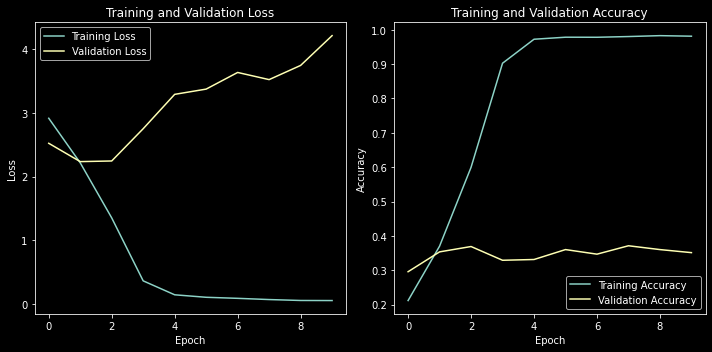

{'precision': 0.4112819957819958,
 'recall': 0.3844444444444444,
 'f1': 0.3796081623143152,
 'class_counts': [7,
  20,
  9,
  5,
  11,
  12,
  13,
  11,
  12,
  5,
  6,
  14,
  3,
  5,
  9,
  3,
  7,
  16,
  5,
  12,
  12,
  7,
  10,
  6,
  6,
  9,
  10,
  3,
  11,
  5,
  13,
  10,
  8,
  16,
  8,
  16,
  10,
  8,
  6,
  3,
  4,
  14,
  4,
  11,
  9,
  14,
  8,
  7,
  7,
  10]}

<Figure size 432x288 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q1_baseline/train_record/train_record_lr0.0001.pkl', 'rb'))
test_record = pickle.load(open('record/Q1_baseline/test_record/test_record_lr0.0001.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
test_record

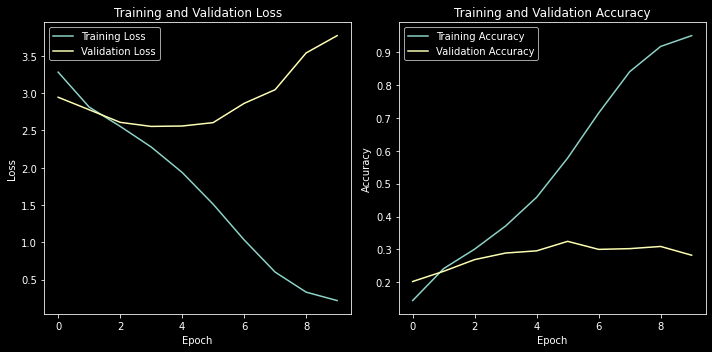

{'precision': 0.36766967729627575,
 'recall': 0.3288888888888889,
 'f1': 0.32315174253066303,
 'class_counts': [8,
  18,
  9,
  5,
  13,
  7,
  10,
  4,
  9,
  6,
  30,
  5,
  9,
  1,
  14,
  17,
  9,
  15,
  11,
  10,
  10,
  8,
  3,
  7,
  10,
  3,
  4,
  5,
  7,
  7,
  4,
  11,
  12,
  9,
  10,
  6,
  3,
  3,
  23,
  4,
  11,
  10,
  4,
  12,
  6,
  9,
  11,
  8,
  9,
  11]}

In [4]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q1_baseline/train_record/train_record_lr1e-05.pkl', 'rb'))
test_record = pickle.load(open('record/Q1_baseline/test_record/test_record_lr1e-05.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
test_record

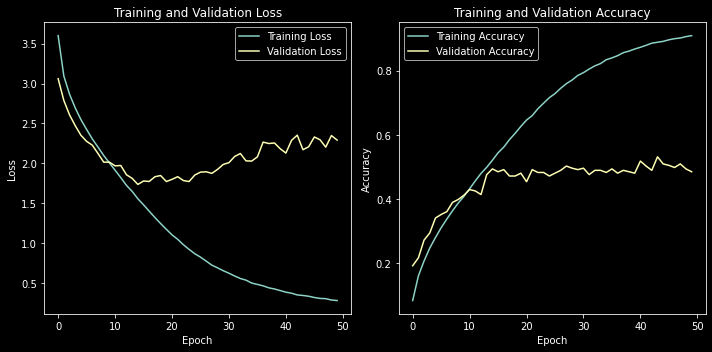

0.49333333333333335

In [34]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q1_baseline/train_record/train_record_lr0.0001_bn_dropout.pkl', 'rb'))
test_record = pickle.load(open('record/Q1_baseline/test_record/test_record_lr0.0001_bn_dropout.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']
num_epochs = 50
# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
valid_acc[14]

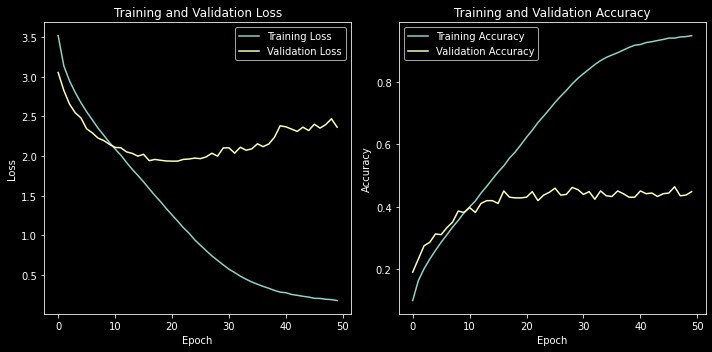

0.4444444444444444

In [18]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q1_baseline/train_record/train_record_lr1e-05_bn_dropout.pkl', 'rb'))
test_record = pickle.load(open('record/Q1_baseline/test_record/test_record_lr1e-05_bn_dropout.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']
num_epochs = 50
# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
valid_acc[45]

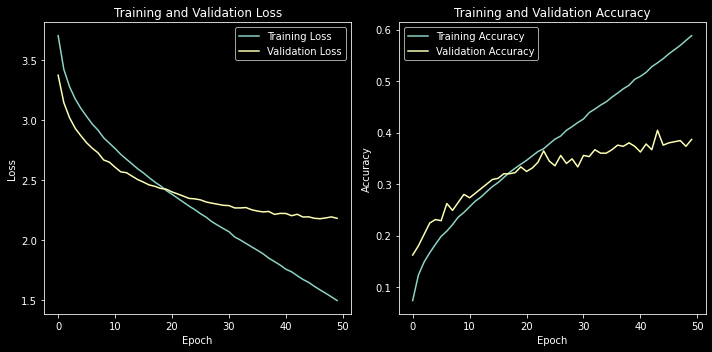

46

In [10]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q1_baseline/train_record/train_record_lr1e-06_bn_dropout.pkl', 'rb'))
test_record = pickle.load(open('record/Q1_baseline/test_record/test_record_lr1e-06_bn_dropout.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']
num_epochs = 50
# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
valid_loss.index(min(valid_loss))